In [ ]:
import pandas as pd
import numpy as np 
import anndata as ad 
import scanpy as sc 

In [1]:
import pysam
import pandas as pd

# Path to the filtered BAM file
filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/filtered_1k_PBMCS_bam.bam' # filtered path for 1k dataset 
# filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/filtered_10k_PBMCS_bam.bam' # filtered bam path for 10k dataset

# List to store rows of data (barcode, gene, UMI)
data = []

# Open the filtered BAM file for reading
with pysam.AlignmentFile(filtered_bam_path, "rb") as bam_file:
    # Iterate over each read in the BAM file
    for read in bam_file:
        # Check if the read has 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
        if read.has_tag('CB') and read.has_tag('GN') and read.has_tag('UB'):
            # Extract the 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
            barcode = read.get_tag('CB')
            gene = read.get_tag('GN')
            umi = read.get_tag('UB')
            
            # Append the row to the data list
            data.append([barcode, gene, umi])

# Convert the list into a pandas DataFrame
df = pd.DataFrame(data, columns=['barcode', 'gene', 'UMI'])


# Filter out UMIs that contain 'N'
df = df[~df['UMI'].str.contains('N')]


# Show the first few rows of the DataFrame
dedup_df = df[["barcode", "gene", "UMI"]].drop_duplicates()
print(dedup_df.head())

              barcode                   gene           UMI
0  GCTGCAGGTTGACGGA-1             AL627309.1  ATGAATTCGTTT
2  CTGCCTATCTTGATTC-1             AL627309.1  CGGGTACTGCGC
3  GCGAGAAAGTTGTAGA-1             AL627309.1  TTGTAAAATACG
4  GGTCTGGTCAGACATC-1             AL627309.1  GGAAATCTGCGT
5  TGAGCGCCACTATGTG-1  AL627309.1;AL627309.3  GTTAGGTCGTTT


### Getting the proportions for A, T, C, G

In [5]:
from collections import Counter

all_UMIs = ''.join(dedup_df['UMI'].values)

# Count the total number of bases 
total_bases = len(all_UMIs)


## Count occurrences of ecah base 
base_counts = Counter(all_UMIs)

print("A:", base_counts.get('A', 0) / total_bases)
print("T:", base_counts.get('T', 0) / total_bases)
print("G:", base_counts.get('G', 0) / total_bases)
print("C:", base_counts.get('C', 0) / total_bases)



A: 0.22835902901003
T: 0.3226892939638041
G: 0.21420459524732946
C: 0.2347470817788364


In [22]:
def compute_proportion(UMIs): 
    """Reads in a numpy array of UMIs and computes the probability of that UMI happening"""
    
    UMIs = np.array(UMIs) # Ensure UMIs is a numpy array
    
    base_log_probs = {
    "A": np.log(0.23),
    "T": np.log(0.32),
    "G": np.log(0.21),
    "C": np.log(0.24)       
    }
    
    umi_probs = []
    for umi in UMIs: 
        log_prob = sum(base_log_probs[base] for base in umi)
        umi_probs.append(np.exp(log_prob))
        # If the UMI contains an invalid base, we can skip it or handle it as needed
        
    
      
    df = pd.DataFrame({"UMI": UMIs, "probs": umi_probs})
    return df

In [23]:
import itertools

### Generate all length 12 UMIs and save them
def write_all_umis_to_txt(filename='/data/dagyeman/cellranger/all_umis_len12.txt', length=12):
    bases = ['A', 'T', 'G', 'C']
    with open(filename, 'w') as f:
        for p in itertools.product(bases, repeat=length):
            f.write(''.join(p) + '\n')

write_all_umis_to_txt("/data/dagyeman/cellranger/all_umis_len12.txt", length=12)

In [24]:
### Load the UMIs
import numpy as np
UMIs = np.loadtxt('/data/dagyeman/cellranger/all_umis_len12.txt', dtype=str)
len(UMIs)

16777216

In [25]:
UMIs

array(['AAAAAAAAAAAA', 'AAAAAAAAAAAT', 'AAAAAAAAAAAG', ...,
       'CCCCCCCCCCCT', 'CCCCCCCCCCCG', 'CCCCCCCCCCCC'], dtype='<U12')

In [26]:
Umi_probs_12 = compute_proportion(UMIs)

In [28]:
len(Umi_probs_12)
Umi_probs_12

,UMI,probs
0,AAAAAAAAAAAA,2.191462e-08
1,AAAAAAAAAAAT,3.048991e-08
2,AAAAAAAAAAAG,2.000900e-08
3,AAAAAAAAAAAC,2.286743e-08
4,AAAAAAAAAATA,3.048991e-08
...,...,...
16777211,CCCCCCCCCCGC,3.195530e-08
16777212,CCCCCCCCCCCA,3.499867e-08
16777213,CCCCCCCCCCCT,4.869380e-08
16777214,CCCCCCCCCCCG,3.195530e-08


In [29]:
### Saving the dataframe to a CSV file
umi_probs_12 = Umi_probs_12.rename(columns={"UMI": "umi", "probs": "prob"})
umi_probs_12.to_csv("/data/dagyeman/cellranger/umi_probs_12.csv", index=False)

In [30]:
### Loading the UMI probabilities from the CSV file
umi_probs_12 = pd.read_csv("/data/dagyeman/cellranger/umi_probs_12.csv")
umi_probs_12.head()

,umi,prob
0,AAAAAAAAAAAA,2.191462e-08
1,AAAAAAAAAAAT,3.048991e-08
2,AAAAAAAAAAAG,2.000900e-08
3,AAAAAAAAAAAC,2.286743e-08
4,AAAAAAAAAATA,3.048991e-08


In [23]:
### Creating all the dataframes for all other lengths
from collections import OrderedDict

umi_probs_11 = pd.DataFrame()
# Truncate UMIs from length 12 to length 11
umi_probs_11['umi'] = umi_probs_12['umi'].str[:-1]
umi_probs_11['prob'] = umi_probs_12['prob'] # keep original probabilities

# This gives us the unique UMIs-11s in the order the first appear
umi_order = umi_probs_11.drop_duplicates(subset='umi')


# Group
umi_probs_sum = umi_probs_11.groupby('umi', as_index=False)['prob'].sum()

umi_probs_11_ordered = pd.merge(
    umi_order[["umi"]],     # keeps original order 
    umi_probs_sum,          # contains summed probabilities
    on='umi', 
    how='left'
)
umi_probs_11 = umi_probs_11_ordered 

# Saving the dataframe to a CSV file
umi_probs_11.to_csv("/data/dagyeman/cellranger/umi_probs_11.csv", index=False)

,umi,prob
0,AAAAAAAAAAA,8.806434e-08
1,AAAAAAAAAAT,1.244418e-07
2,AAAAAAAAAAG,8.260582e-08
3,AAAAAAAAAAC,9.052782e-08
4,AAAAAAAAATA,1.244418e-07
...,...,...
4194299,CCCCCCCCCGC,1.088506e-07
4194300,CCCCCCCCCCA,1.160433e-07
4194301,CCCCCCCCCCT,1.639784e-07
4194302,CCCCCCCCCCG,1.088506e-07


In [31]:
for i in range(1, 12): 

    umi_probs = pd.DataFrame()
    # Truncate UMIs from length 12 to length i
    umi_probs['umi'] = umi_probs_12['umi'].str[:-i]
    umi_probs['prob'] = umi_probs_12['prob']  # keep original probabilities

    # This gives us the unique UMIs-i in the order the first appear
    umi_order = umi_probs.drop_duplicates(subset='umi')

    # Group
    umi_probs_sum = umi_probs.groupby('umi', as_index=False)['prob'].sum()

    umi_probs_ordered = pd.merge(
        umi_order[["umi"]],     # keeps original order 
        umi_probs_sum,          # contains summed probabilities
        on='umi', 
        how='left'
    )
    
    umi_probs = umi_probs_ordered 

    # Saving the dataframe to a CSV file
    j = 12-i
    umi_probs.to_csv(f"/data/dagyeman/cellranger/umi_probs/umi_probs_{j}.csv", index=False)

In [27]:
umi_probs_dict = {}

for i in range(1,13):
    umi_probs = pd.read_csv(f"/data/dagyeman/cellranger/umi_probs/umi_probs_{i}.csv")
    umi_probs_dict[i] = umi_probs

In [35]:
umi_probs_dict[3]

,umi,prob
0,AAA,0.011908
1,AAT,0.016828
2,AAG,0.011170
3,AAC,0.012242
4,ATA,0.016828
...,...,...
59,CGC,0.011804
60,CCA,0.012584
61,CCT,0.017782
62,CCG,0.011804


### Creating Inverted Adata Matrices with Unif Model

In [8]:
import numpy as np
import pandas as pd
import scanpy as sc 
import anndata as ad



def mom_estimator(prob_arr, matrix, j, n_max =  15000):
    """Inverts entry in the matrix using the method of moments """
    
    n_values = np.linspace(1, n_max, n_max)
    f_hat_values = np.array([4**j - np.sum((1 - prob_arr)**n) for n in n_values])
    
    ## Flatten the matrix
    flat = matrix.flatten()
    
    def invert_single(y):
        i = np.searchsorted(f_hat_values, y) - 1
        i = np.clip(i, 0, len(f_hat_values) - 2)
        
        n_i = n_values[i]
        n_ip1 = n_values[i + 1]
        f_ni = f_hat_values[i]
        f_nip1 = f_hat_values[i + 1]

        
        denom = f_nip1 - f_ni
        if denom == 0:
            return n_i
        else:
            return n_i + (y - f_ni) * (n_ip1 - n_i) / denom

    invert_vec = np.vectorize(invert_single)
    predicted_flat = invert_vec(flat)
    
    ### Reshape to original shape
    return predicted_flat.reshape(matrix.shape)
    

In [43]:
import scanpy as sc
import anndata as ad

filepath = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects"

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"{filepath}/adata_matrices/adata_{i}.h5ad")

umi_prob_dict = {}
for i in range(1, 13):
    umi_prob_dict[i] = pd.read_csv(f"/data/dagyeman/cellranger/umi_probs/umi_probs_{i}.csv")
    

for k in range(1, 13): 
    adata = adata_dict[k]
    umi_probs = umi_prob_dict[k]
    original_matrix = adata.X.copy()
    
    matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    predicted_matrix = mom_estimator(umi_prob_dict[k]['prob'].values, matrix, j=k)
    
    
    
    new_adata = ad.AnnData(X=predicted_matrix, obs=adata.obs.copy(), var=adata.var.copy())
    out_path = f"{filepath}/inv_nonunif_matrices/adata_{k}.h5ad"
    new_adata.write_h5ad(out_path)
    
    print(f"New predicted gene expression matrix saved for UMI length {k} to: {out_path}")


New predicted gene expression matrix saved for UMI length 1 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_1.h5ad
New predicted gene expression matrix saved for UMI length 2 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_2.h5ad
New predicted gene expression matrix saved for UMI length 3 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_3.h5ad
New predicted gene expression matrix saved for UMI length 4 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_4.h5ad
New predicted gene expression matrix saved for UMI length 5 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_5.h5ad
New predicted gene expression matrix saved for UMI length 6 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_6.h5ad
New predicted gene expressio

In [10]:

### NOTE: Inverting the  matrix for adata_12

import scanpy as sc
import anndata as ad

filepath = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects"

### Read in the adata 12 matrix
adata = sc.read_h5ad(f"{filepath}/adata_matrices/adata_12.h5ad")


### Read in the UMI probabilities for length 12
umi_prob_12 = pd.read_csv(f"/data/dagyeman/cellranger/umi_probs/umi_probs_12.csv")

### Get a copy of the original matrix
original_matrix = adata.X.copy()  

### Use the mom_estimator function to predict the matrix
matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
predicted_matrix = mom_estimator(umi_prob_12['prob'].values, matrix, j=12)
    
    
### Create a new AnnData object with the predicted matrix
new_adata = ad.AnnData(X=predicted_matrix, obs=adata.obs.copy(), var=adata.var.copy())
out_path = f"{filepath}/inv_nonunif_matrices/adata_12.h5ad"
new_adata.write_h5ad(out_path)
    
print(f"New predicted gene expression matrix saved for UMI length 12 to: {out_path}")

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

file_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects"

adata_inv_dict = {
    i: sc.read_h5ad(f"{file_path}/inv_nonunif_matrices/adata_{i}.h5ad")
    for i in range(1, 12)
}

ground_truth = sc.read_h5ad(f"{file_path}/adata_matrices/adata_12.h5ad")

for j in range(1, 12):
    adata = adata_inv_dict[j]

    common_barcodes = set(adata.obs_names).intersection(ground_truth.obs_names)
    print(f"Number of common barcodes for UMI length {j}: {len(common_barcodes)}")

    barcode_list = list(common_barcodes)
    i_indices = [ground_truth.obs_names.get_loc(barcode) for barcode in barcode_list]
    j_indices = [adata.obs_names.get_loc(barcode) for barcode in barcode_list]

    X_i = ground_truth.X[i_indices]
    X_j = adata.X[j_indices]

    mask = X_i >= 1
    filtered_counts_i = X_i[mask]
    filtered_counts_j = X_j[mask]

    all_gene_counts_i = np.array(filtered_counts_i)
    all_gene_counts_j = np.array(filtered_counts_j)
    print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

    # Sort the gene counts based on ground truth
    sorted_indices = np.argsort(all_gene_counts_i)
    sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
    sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

    plt.figure(figsize=(10, 10))
    plt.scatter(
        sorted_gene_counts_i,
        sorted_gene_counts_j,
        alpha=0.5,
        c='#1f77b4',
        edgecolors='w',
        s=100,
        linewidth=0.5,
        label='Observed counts'
    )

    # Plot y = x line
    # If X matrices are sparse, you may need .toarray() here
    max_val = max(ground_truth.X.max(), adata.X.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Ground Truth Expression')
    plt.ylabel('Predicted Expression')
    plt.title(f'Predicted vs Ground Truth Expression for UMI Length {j}')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


## Total variation distance

In [1]:
import scanpy as sc
import numpy as np   
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

file_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects"

adata_12 = sc.read_h5ad(f"{file_path}/adata_matrices/adata_12.h5ad")

naive_matrices = {
    i: sc.read_h5ad(f"{file_path}/adata_matrices/adata_{i}.h5ad")
    for i in range(1, 12)
}

uniform_matrices = {
    i: sc.read_h5ad(f"{file_path}/inv_unif_matrices/adata_{i}.h5ad")
    for i in range(1, 12)
}

non_unif_matrices = {
    i: sc.read_h5ad(f"{file_path}/inv_nonunif_matrices/adata_{i}.h5ad")
    for i in range(1, 12)
}





[0.3368852001722949, 0.21176016361166244, 0.10595201467199507, 0.04465060728021486, 0.017968891065187446, 0.007860886158858675, 0.004016777441768168, 0.0024429705490248517, 0.0016631036278363723, 0.0010247961546732093, 0.00038425499939834576, 0.0]
[0.2846129458250203, 0.10970751580117084, 0.04026084059723804, 0.019702735930069683, 0.009760108038236324, 0.005405813366971701, 0.0033586245417196042, 0.0022919765335257976, 0.0016310172085561353, 0.0010198287254215707, 0.000384253151749912, 9.190439373920128e-07]
[0.2889504819215407, 0.1055309611582611, 0.03666628821529145, 0.017400471023131543, 0.008661108811398088, 0.004997525913480286, 0.0032680842270718493, 0.0022601534705541733, 0.0016250485787615483, 0.0010192020102711375, 0.0003843783916711162, 0.0]


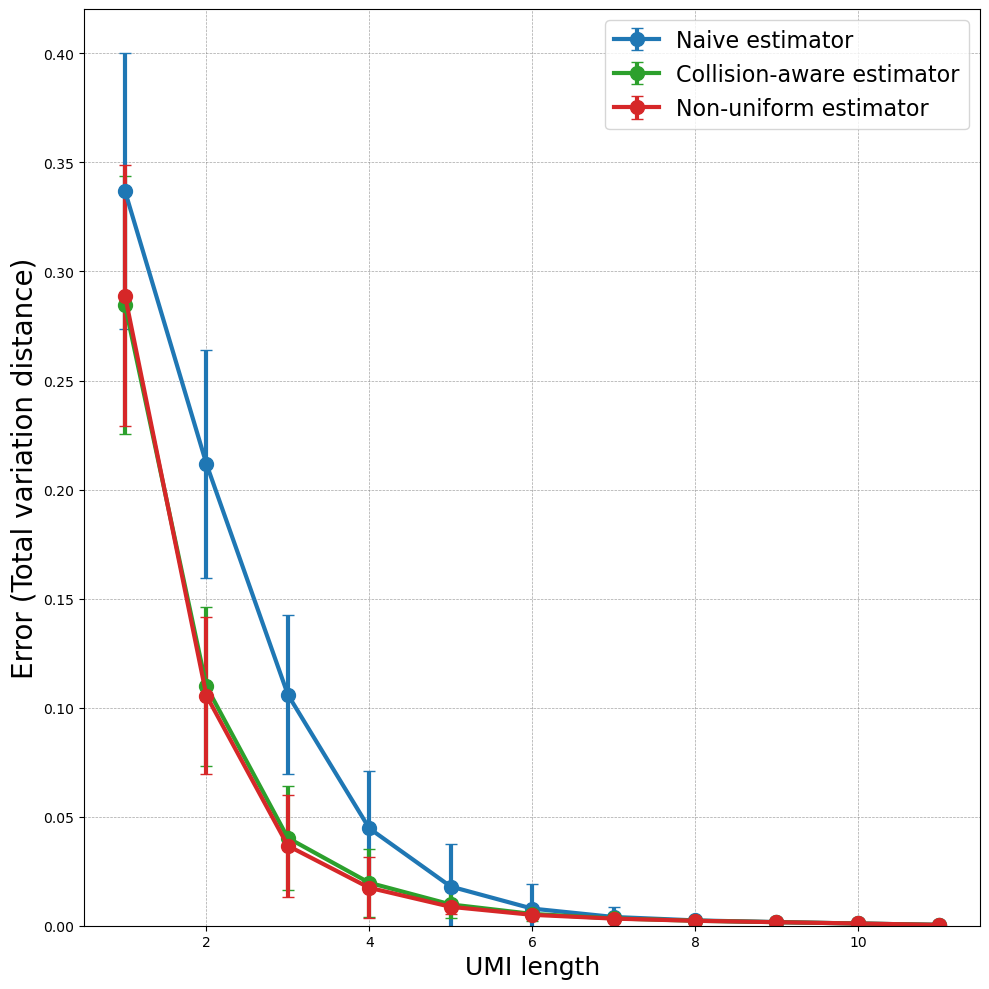

In [60]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted unif matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_unif_matrices"
# common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" 
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    unif_adata_dict[i] = sc.read_h5ad(path)
    
# Loadin the inverted non-unif matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    non_unif_adata_dict[i] = sc.read_h5ad(path)
non_unif_adata_dict[12] = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []
mean_errors3 = []
std_errors3 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for unif_matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = unif_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts2 >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))
    
    errors3 = []
    for barcode in gt_adata12.obs_names:
        index3 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts3 = non_unif_adata_dict[i].X[index3]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts3, np.ndarray):
            gene_counts3 = gene_counts3.toarray().flatten()
        else:
            gene_counts3 = gene_counts3.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts3
        mask = gene_counts3 >= 1
        gene_counts3 = gene_counts3[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts3)
        sorted_gene_counts3 = gene_counts3[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error3 = tvd(sorted_gene_counts3, sorted_gene_counts_gt)
        errors3.append(error3)  
        
    mean_errors3.append(np.mean(errors3))
    std_errors3.append(np.std(errors3))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)


# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#d62728',        # Red for Non-uniform Estimator
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()

/tmp/ipykernel_4138550/2180689706.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)  # Adjust the y-axis limits as needed


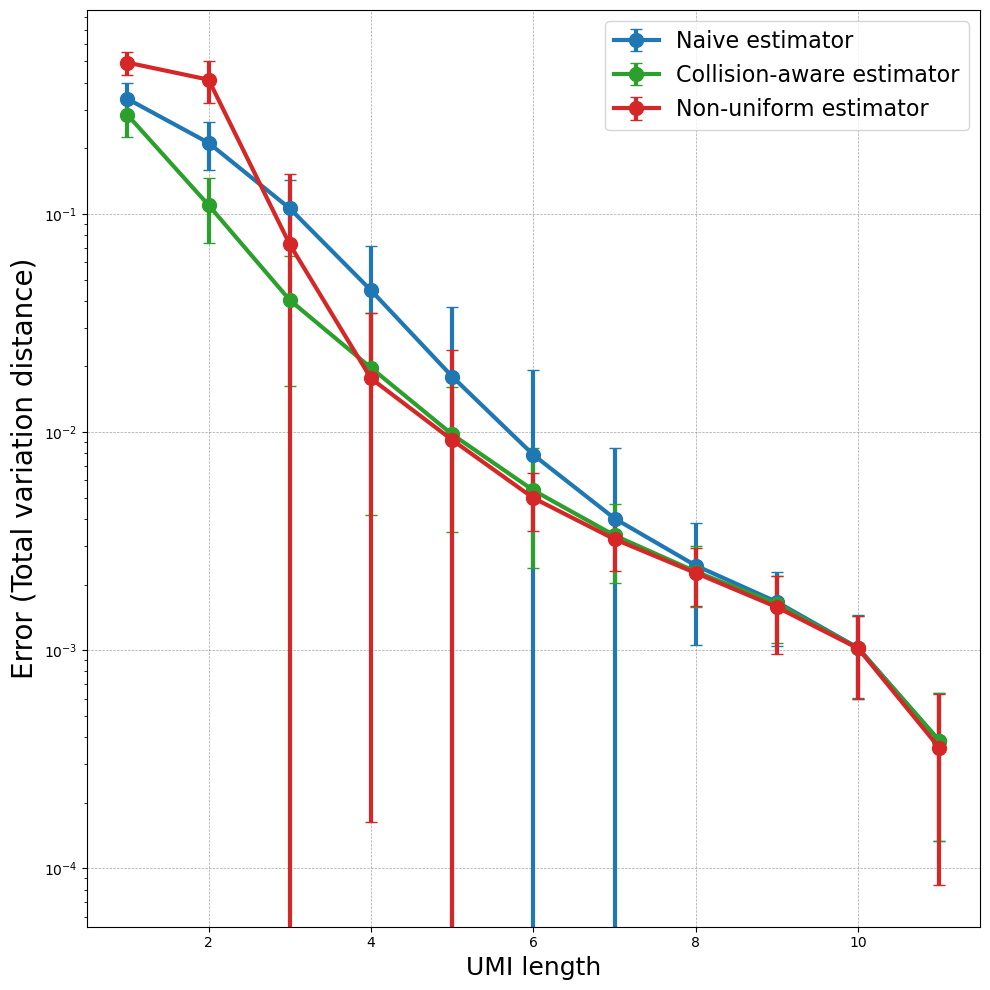

In [16]:
plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#d62728',        # Red for Non-uniform Estimator
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# Labels and grid
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)  # Adjust the y-axis limits as needed
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()


# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs

In [18]:
# def mom_estimator(prob_arr, matrix, j, n_max =  15000):
#     """Inverts entry in the matrix using the method of moments """
    
#     n_values = np.linspace(1, n_max, n_max)
#     f_hat_values = np.array([4**j - np.sum((1 - prob_arr)**n) for n in n_values])
    
#     ## Flatten the matrix
#     flat = matrix.flatten()
    
#     def invert_single(y):
#         i = np.searchsorted(f_hat_values, y) - 1
#         i = np.clip(i, 0, len(f_hat_values) - 2)
        
#         n_i = n_values[i]
#         n_ip1 = n_values[i + 1]
#         f_ni = f_hat_values[i]
#         f_nip1 = f_hat_values[i + 1]

        
#         denom = f_nip1 - f_ni
#         if denom == 0:
#             return n_i
#         else:
#             return n_i + (y - f_ni) * (n_ip1 - n_i) / denom

#     invert_vec = np.vectorize(invert_single)
#     predicted_flat = invert_vec(flat)
    
#     ### Reshape to original shape
#     return predicted_flat.reshape(matrix.shape)

In [ ]:


# def mom_estimator(prob_arr, matrix, j, n_max =  15000):
#     """Inverts entry in the matrix using the method of moments """
    
#     n_values = np.linspace(1, n_max, n_max)
#     f_hat_values = np.array([4**j - np.sum((1 - prob_arr)**n) for n in n_values])
    
#     ## Flatten the matrix
#     flat = matrix.flatten()
    
#     def invert_single(y):
#         if y = 4**j:
#             return 
#         i = np.searchsorted(f_hat_values, y) - 1
#         i = np.clip(i, 0, len(f_hat_values) - 2)
        
#         n_i = n_values[i]
#         n_ip1 = n_values[i + 1]
#         f_ni = f_hat_values[i]
#         f_nip1 = f_hat_values[i + 1]

        
#         denom = f_nip1 - f_ni
#         if denom == 0:
#             return n_i
#         else:
#             return n_i + (y - f_ni) * (n_ip1 - n_i) / denom

#     invert_vec = np.vectorize(invert_single)
#     predicted_flat = invert_vec(flat)
    
#     ### Reshape to original shape
#     return predicted_flat.reshape(matrix.shape)

## Uniform Estimaor

In [7]:
def mom_estimator_unif(y, K):
    # Convert input to a NumPy array (if not already)
    y = np.array(y)
    
    # Preallocate a result array of floats with the same shape as y.
    result = np.empty_like(y, dtype=float)
    
    # First, handle the special case: where y == K.
    special_mask = (y == K)
    if special_mask.any():
        # Compute the special value using the recursive formula.
        special_value = mom_estimator(K - 1, K) + K
        result[special_mask] = special_value
    
    # Then, compute the original (general) case only for entries where y != K.
    general_mask = ~special_mask
    if general_mask.any():
        denominator = np.log(1 - 1/K)
        result[general_mask] = np.log(1 - y[general_mask] / K) / denominator
    
    return result  

## The New Method of Moments Estimator 1

In [58]:
import numpy as np
from numba import njit, prange

@njit
def interpolate(y, f_hat_values, n_values):
    """Interpolates the value of n for a given y using linear interpolation."""
    if y == 0:
        return 0
    i = np.searchsorted(f_hat_values, y) - 1
    i = max(0, min(i, len(f_hat_values) - 2))

    n_i = n_values[i]
    n_ip1 = n_values[i + 1]
    f_ni = f_hat_values[i]
    f_nip1 = f_hat_values[i + 1]

    denom = f_nip1 - f_ni
    return  n_i + (y - f_ni) * (n_ip1 - n_i) / denom

@njit(parallel=True)
def interpolate_array(matrix_flat, f_hat_values, n_values, j):
    """Takes an array, flattens it and applies interpolation for each element."""
    result = np.empty_like(matrix_flat)
    target_value = 4 ** j

    for idx in prange(matrix_flat.size):
        y = matrix_flat[idx]
        if y == target_value:
            ### Edge case: extrapolate from y-1 and y-2
            result[idx] = 3*interpolate(y - 1, f_hat_values, n_values) - 3*interpolate(y - 2, f_hat_values, n_values) + interpolate(y - 3, f_hat_values, n_values)
        else:
            result[idx] = interpolate(y, f_hat_values, n_values)
    return result

def mom_estimator_new(prob_arr, matrix, j, n_max=15000):
    """Returns the inverted matrix using the method of moments."""

    n_values     = np.linspace(1, n_max, n_max)
    f_hat_values = np.array([4**j - np.sum((1 - prob_arr)**n) for n in n_values])

    matrix_flat = matrix.flatten().astype(np.float64)

    # Pre-check to avoid out-of-bounds interpolation (but allow exactly 4**j)
    f_min, f_max = f_hat_values[0], f_hat_values[-1]
    target       = 4**j
    mask = (matrix_flat > f_max) & (matrix_flat != target)
    out_of_bounds = matrix_flat[mask]
    if out_of_bounds.size > 0:
        print(f"Out-of-bounds y-values: {out_of_bounds}")
        raise ValueError(f"Some y-values are outside interpolation range [{f_min}, {f_max}].")
        return "Failed to invert matrix due to out-of-bounds values."

    interpolated_flat = interpolate_array(matrix_flat, f_hat_values, n_values, j)
    return interpolated_flat.reshape(matrix.shape)







array([4194303.25      , 4194303.4375    , 4194303.578125  ,
       4194303.68359375, 4194303.76269531])

In [33]:
import pandas as pd
umi_prob_dict = {}
for i in range(1, 13):
    umi_probs = pd.read_csv(f"/data/dagyeman/cellranger/umi_probs/umi_probs_{i}.csv")
    umi_prob_dict[i] = umi_probs


### Edge case with uniform mom_estimator 

In [36]:
umi_prob_dict[1].head()

,umi,prob
0,A,0.23
1,T,0.32
2,G,0.21
3,C,0.24


In [40]:
i = 12
d = np.array(4**i)
value = mom_estimator_unif(d, 4**i)
print(f"Input value: {4**i}, Inverted value (Uniform): {value}")


Input value: 16777216, Inverted value (Uniform): 295875126.9153186


### Edge case with old mom_estimator 

In [36]:
# i = 5
# matrix = np.array([4**i])
# prob_arr = umi_prob_dict[i]['prob'].values
# print(f"Input value: {4**i}, Inverted value: {mom_estimator(prob_arr, matrix,  i, 15000)}")

Input value: 1024, Inverted value: [16782.8697923]


### Edge case with new mom_estimator_new function

In [14]:

i = 1
matrix = np.array([4**i])
prob_arr = umi_prob_dict[i]['prob'].values
print(f"Input value:{4**i}, Inverted value Non-uniform: {mom_estimator_new(prob_arr, matrix,  i, 15000)}")

Input value:4, Inverted value: [7.394955]


In [21]:
print("(Value", "Unif Estimator", "Non-unif Estimator)")
for i in range(1, 6): 
    matrix = np.array([4**i])
    prob_arr = umi_prob_dict[i]['prob'].values
    
    print((4**i, float(mom_estimator_unif(matrix, 4**i)), float(mom_estimator_new(prob_arr, matrix,  i, 15000))))

(Value Unif Estimator Non-unif Estimator)
(4, 8.818841679306418, 7.394954999372867)
(16, 58.96021466512525, 58.304138734782725)


/tmp/ipykernel_138904/3560323158.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print((4**i, float(mom_estimator_unif(matrix, 4**i)), float(mom_estimator_new(prob_arr, matrix,  i, 15000))))


(64, 328.08361785128415, 360.23862964842306)
(256, 1672.7910284594705, 2033.6753730469165)
(1024, 8118.360828670819, 10962.591526237466)


### Generating the adata matrices

In [59]:
import scanpy as sc
import anndata as ad

filepath = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects"

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"{filepath}/adata_matrices/adata_{i}.h5ad")

umi_prob_dict = {}
for i in range(1, 13):
    umi_prob_dict[i] = pd.read_csv(f"/data/dagyeman/cellranger/umi_probs/umi_probs_{i}.csv")
    

for k in range(1, 13): 
    adata = adata_dict[k]
    umi_probs = umi_prob_dict[k]
    original_matrix = adata.X.copy()
    
    matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    predicted_matrix = mom_estimator_new(umi_prob_dict[k]['prob'].values, matrix, j=k)
    
    
    
    new_adata = ad.AnnData(X=predicted_matrix, obs=adata.obs.copy(), var=adata.var.copy())
    out_path = f"{filepath}/inv_nonunif_matrices/adata_{k}.h5ad"
    new_adata.write_h5ad(out_path)
    
    print(f"New predicted gene expression matrix saved for UMI length {k} to: {out_path}")

New predicted gene expression matrix saved for UMI length 1 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_1.h5ad
New predicted gene expression matrix saved for UMI length 2 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_2.h5ad
New predicted gene expression matrix saved for UMI length 3 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_3.h5ad
New predicted gene expression matrix saved for UMI length 4 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_4.h5ad
New predicted gene expression matrix saved for UMI length 5 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_5.h5ad
New predicted gene expression matrix saved for UMI length 6 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_6.h5ad
New predicted gene expressio

### TVD 

## Forward Modeling

#### All genes, all cells

Total common barcodes: 1232
Total filtered gene counts: 4283561


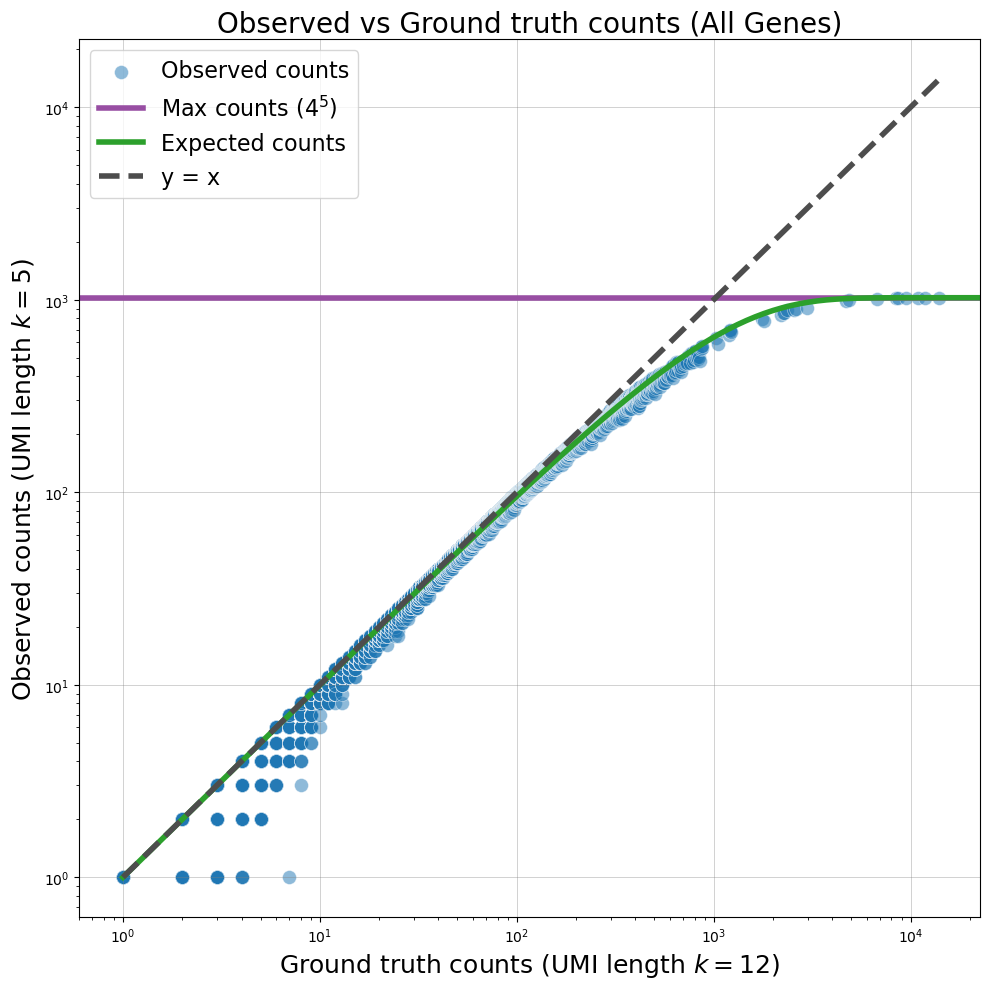

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

adata_dict = {}
adata_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"{adata_path}/adata_{i}.h5ad")

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = sorted(set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

barcode_list = list(common_barcodes)
indices_i = [adata_dict[i].obs_names.tolist().index(barcode) for barcode in barcode_list]
indices_j = [adata_dict[j].obs_names.tolist().index(barcode) for barcode in barcode_list]

# Pull full matrices at once
X_i = adata_dict[i].X[indices_i]
X_j = adata_dict[j].X[indices_j]


mask = X_i >= 1


# Filter using the mask 
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]


# Convert to numpy arrays if they are sparse matrices
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]



# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# Plot the model
model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=4, 
    label='Expected counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.title("Observed vs Ground truth counts (All Genes)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()


#### All genes, all cells, without MALAT1

Total common barcodes: 1232
Total filtered gene counts (post-remove): 4282363


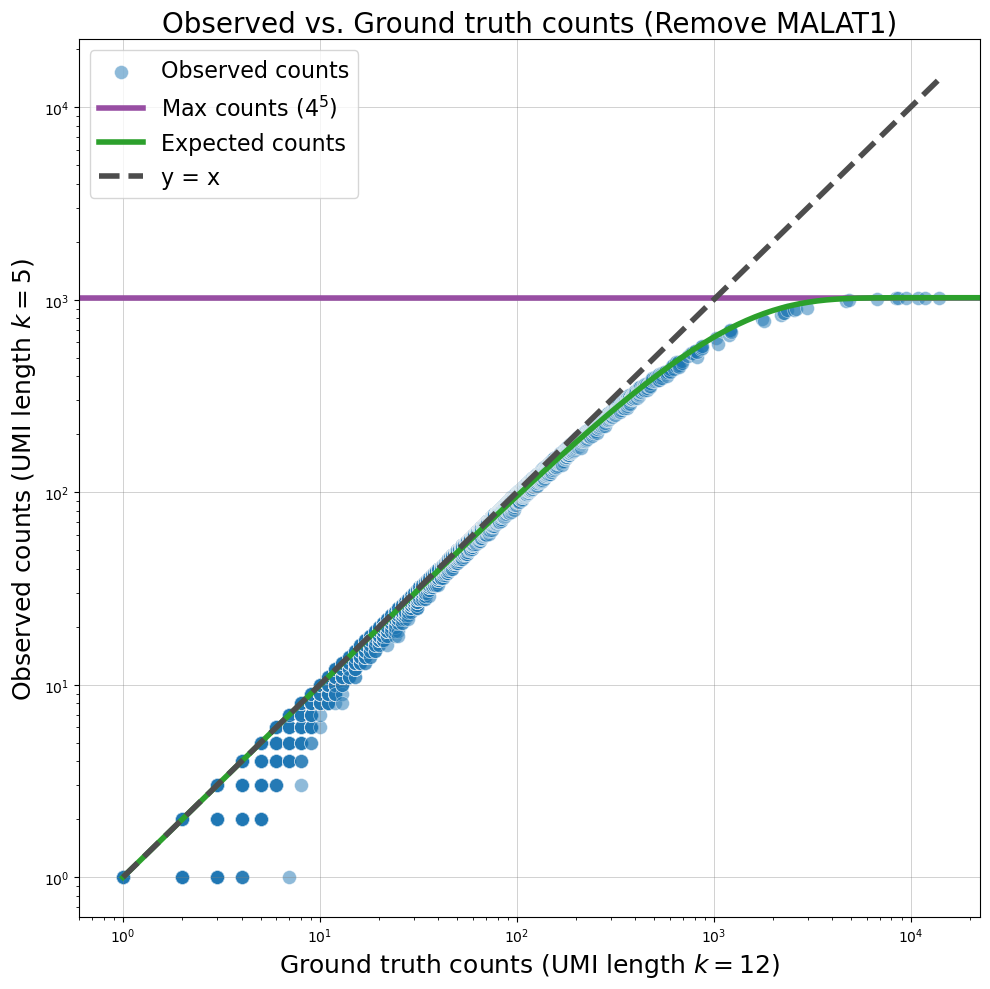

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Define which genes to remove
remove = np.array([
    "MALAT1",
    # add any other gene names you want to drop here
])

adata_dict = {}
adata_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"{adata_path}/adata_{i}.h5ad")

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = sorted(
    set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
)
print(f"Total common barcodes: {len(common_barcodes)}")

barcode_list = list(common_barcodes)
indices_i = [adata_dict[i].obs_names.tolist().index(barcode) for barcode in barcode_list]
indices_j = [adata_dict[j].obs_names.tolist().index(barcode) for barcode in barcode_list]

# Create a mask for genes to **keep** (i.e. not in 'remove')
gene_mask = ~np.isin(adata_dict[i].var_names, remove)

# Pull full matrices at once, subsetting both cells and genes
X_i = adata_dict[i].X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

# Create a mask for the filtered counts (based on X_i >= 1)
mask = X_i >= 1

# Filter using the mask 
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

# Convert to numpy arrays if they are sparse matrices
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts (post-remove): {len(all_gene_counts_i)}")

# Sort by the ground-truth counts
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Create plot (unchanged styling)
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# Plot the model
model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=4, 
    label='Expected counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.title("Observed vs. Ground truth counts (Remove MALAT1)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

plt.tight_layout()
plt.show()
plt.close()


In [20]:
max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())

13973.0

#### Protein Coding Genes only

In [23]:
pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
npc_list = np.loadtxt("/data/dagyeman/cellranger/1k_non_protein_coding_genes.txt", dtype=str)
print(len(pc_list), len(npc_list))

19389 17205


Total common barcodes: 1232
Total filtered gene counts (post-keep): 3930165


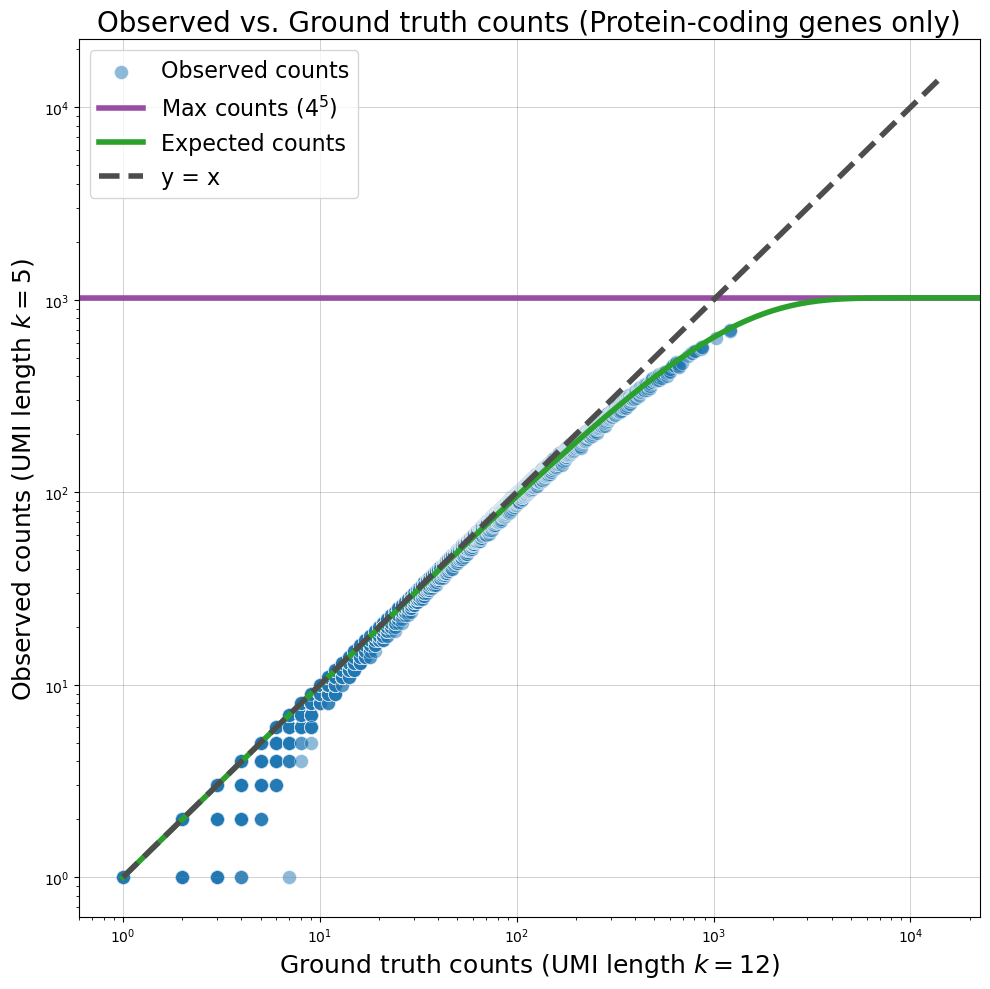

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc



adata_dict = {}
adata_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"{adata_path}/adata_{i}.h5ad")

def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

common_barcodes = sorted(
    set(adata_dict[i].obs_names).intersection(adata_dict[j].obs_names)
)
print(f"Total common barcodes: {len(common_barcodes)}")

barcode_list = list(common_barcodes)
indices_i = [adata_dict[i].obs_names.tolist().index(barcode) for barcode in barcode_list]
indices_j = [adata_dict[j].obs_names.tolist().index(barcode) for barcode in barcode_list]


pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
keep = np.array(pc_list)
# <-- this line changed: now keep only genes in `keep` -->
gene_mask = np.isin(adata_dict[i].var_names, keep)

X_i = adata_dict[i].X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

mask = X_i >= 1
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts (post-keep): {len(all_gene_counts_i)}")

sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4', 
    edgecolors='w', 
    s=100, 
    linewidth=0.5, 
    label='Observed counts'
)

y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c', 
    linewidth=4, 
    label='Expected counts'
)

# max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, 14*1e3], [1, 14*1e3], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)

plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)
plt.title("Observed vs. Ground truth counts (Protein-coding genes only)", fontsize=20)
plt.tight_layout()
plt.show()
plt.close()


## Inverted Modeling

#### All genes

Total common barcodes: 1232
Total filtered gene counts: 4283561


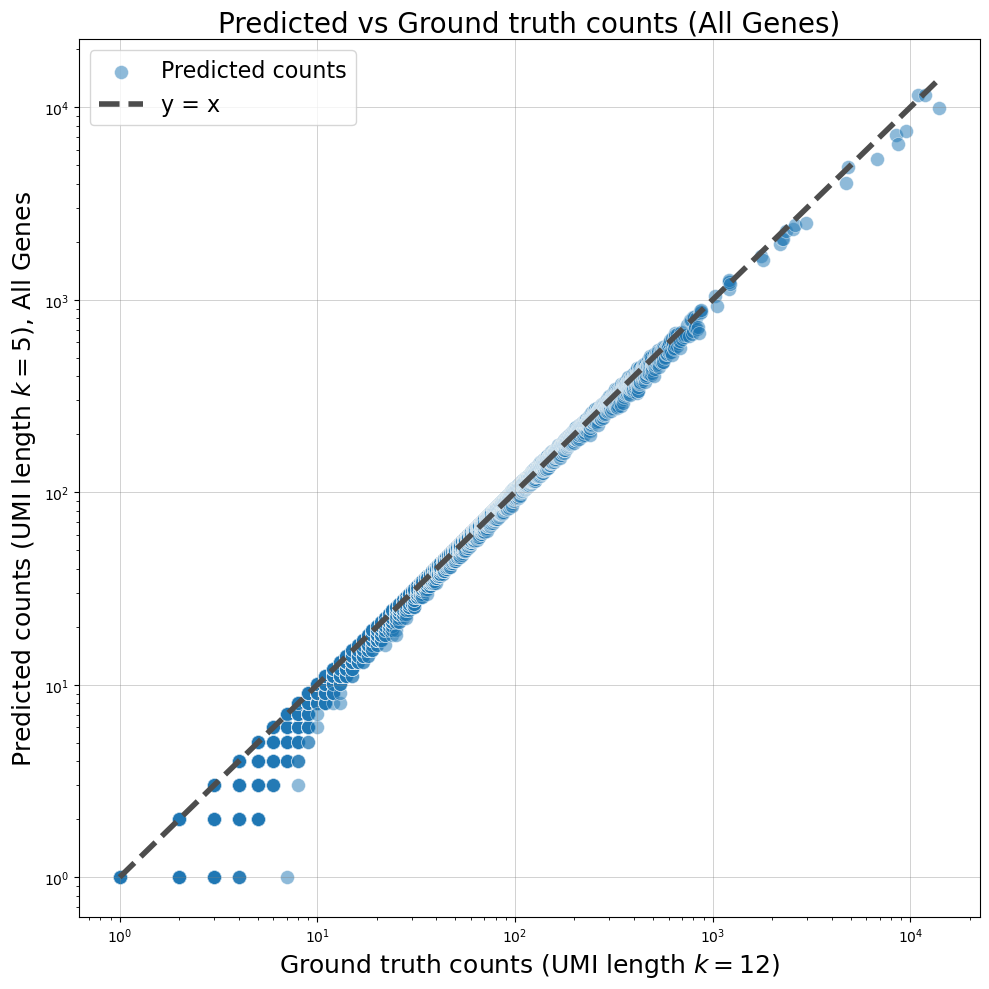

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{i}.h5ad")
    
    
# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = sorted(set(adata_12.obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

barcode_list = list(common_barcodes)
indices_i = [adata_12.obs_names.tolist().index(barcode) for barcode in barcode_list]
indices_j = [adata_dict[j].obs_names.tolist().index(barcode) for barcode in barcode_list]

# Pull full matrices at once
X_i = adata_12.X[indices_i]
X_j = adata_dict[j].X[indices_j]


mask = X_i >= 1


# Filter using the mask 
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]


# Convert to numpy arrays if they are sparse matrices
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]



# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Predicted counts'
)

# Add the asymptotic line for UMI 5
# y_asymptotic_value = 4**j
# plt.axhline(
#     y=y_asymptotic_value, 
#     color='#984ea3', 
#     linestyle='-', 
#     linewidth=4, 
#     label=f'Max counts ($4^{{{j}}}$)'
# )

# # Plot the model
# model_vals = f(n_values, j)
# plt.plot(
#     n_values, 
#     model_vals, 
#     color='#2ca02c',  # Standard Green for Model Line
#     linewidth=4, 
#     label='Expected counts'
# )

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Predicted counts (UMI length $k=5$), All Genes", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.title("Predicted vs Ground truth counts (All Genes)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()


#### All genes, Renove MALALT1

Total common barcodes: 1232
Total filtered gene counts: 4282363


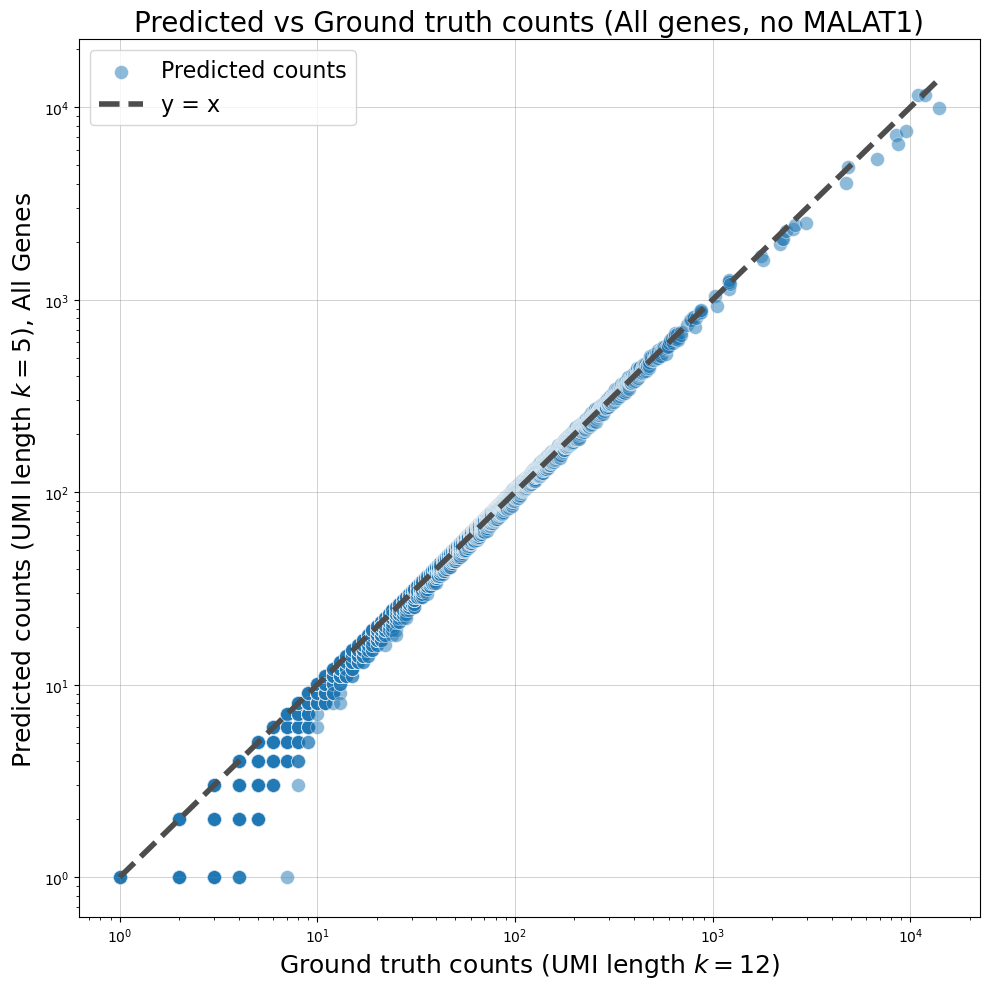

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{i}.h5ad")
    

# Define which genes to remove
remove = np.array([
    "MALAT1",
    # add any other gene names you want to drop here
])
 
# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = sorted(set(adata_12.obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

barcode_list = list(common_barcodes)
indices_i = [adata_12.obs_names.tolist().index(barcode) for barcode in barcode_list]
indices_j = [adata_dict[j].obs_names.tolist().index(barcode) for barcode in barcode_list]

# Create a mask for genes to **keep** (i.e. not in 'remove')
gene_mask = ~np.isin(adata_12.var_names, remove)

# Pull full matrices at once, subsetting both cells and genes
X_i = adata_12.X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

mask = X_i >= 1


# Filter using the mask 
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]


# Convert to numpy arrays if they are sparse matrices
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]



# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Predicted counts'
)

# Add the asymptotic line for UMI 5
# y_asymptotic_value = 4**j
# plt.axhline(
#     y=y_asymptotic_value, 
#     color='#984ea3', 
#     linestyle='-', 
#     linewidth=4, 
#     label=f'Max counts ($4^{{{j}}}$)'
# )

# # Plot the model
# model_vals = f(n_values, j)
# plt.plot(
#     n_values, 
#     model_vals, 
#     color='#2ca02c',  # Standard Green for Model Line
#     linewidth=4, 
#     label='Expected counts'
# )

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Predicted counts (UMI length $k=5$), All Genes ", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.title("Predicted vs Ground truth counts (All genes, no MALAT1)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()


#### Protein Coding Genes

Total common barcodes: 1232
Total filtered gene counts: 3930165


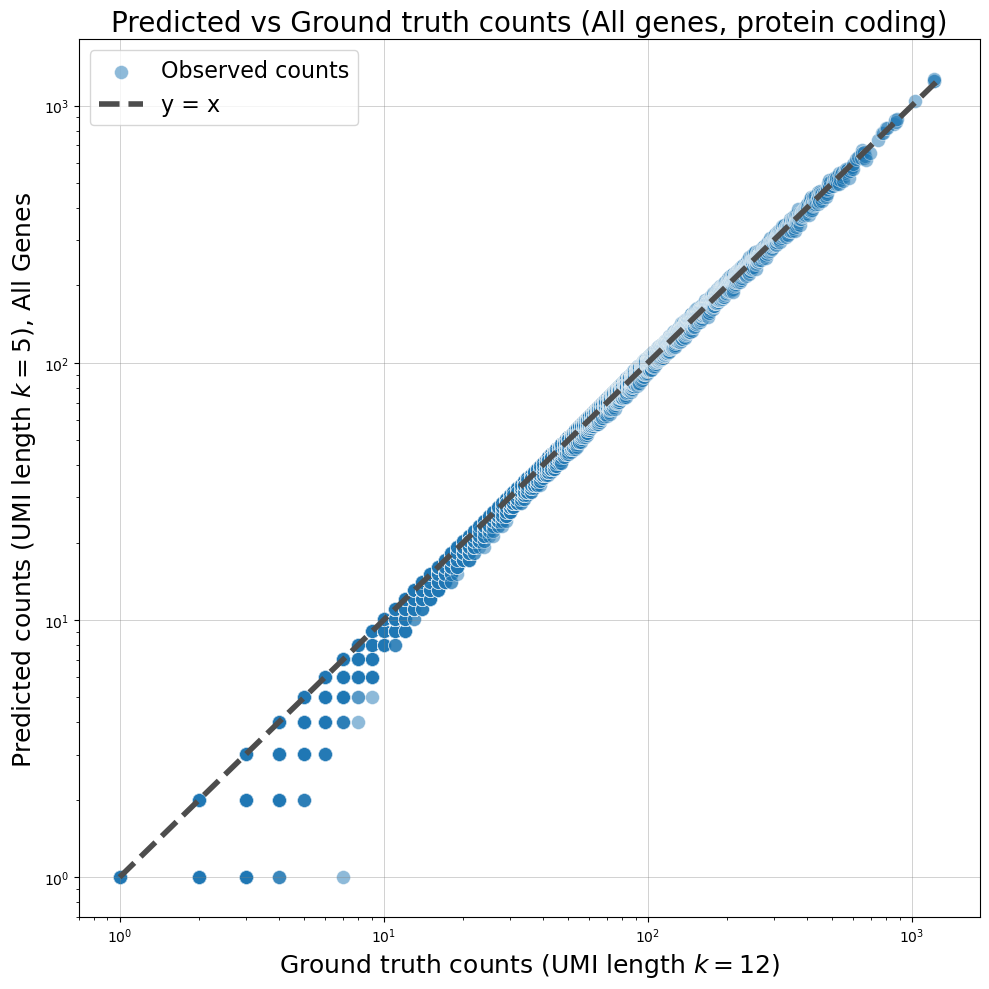

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{i}.h5ad")
    

 
# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = sorted(set(adata_12.obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

barcode_list = list(common_barcodes)
indices_i = [adata_12.obs_names.tolist().index(barcode) for barcode in barcode_list]
indices_j = [adata_dict[j].obs_names.tolist().index(barcode) for barcode in barcode_list]


pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
keep = np.array(pc_list)
# <-- this line changed: now keep only genes in `keep` -->
gene_mask = np.isin(adata_12.var_names, keep)

# Pull full matrices at once, subsetting both cells and genes
X_i = adata_12.X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

mask = X_i >= 1



# Filter using the mask 
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]


# Convert to numpy arrays if they are sparse matrices
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]



# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
# y_asymptotic_value = 4**j
# plt.axhline(
#     y=y_asymptotic_value, 
#     color='#984ea3', 
#     linestyle='-', 
#     linewidth=4, 
#     label=f'Max counts ($4^{{{j}}}$)'
# )

# # Plot the model
# model_vals = f(n_values, j)
# plt.plot(
#     n_values, 
#     model_vals, 
#     color='#2ca02c',  # Standard Green for Model Line
#     linewidth=4, 
#     label='Expected counts'
# )

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Predicted counts (UMI length $k=5$), All Genes ", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.title("Predicted vs Ground truth counts (All genes, protein coding)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()


## TVD

#### All genes 

[0.3368852001722949, 0.21176016361166244, 0.10595201467199507, 0.04465060728021486, 0.017968891065187446, 0.007860886158858675, 0.004016777441768168, 0.0024429705490248517, 0.0016631036278363723, 0.0010247961546732093, 0.00038425499939834576, 0.0]
[0.2846129458250203, 0.10970751580117084, 0.04026084059723804, 0.019702735930069683, 0.009760108038236324, 0.005405813366971701, 0.0033586245417196042, 0.0022919765335257976, 0.0016310172085561353, 0.0010198287254215707, 0.000384253151749912, 9.190439373920128e-07]
[0.2889504819215407, 0.1055309611582611, 0.03666628821529145, 0.017400471023131543, 0.008661108811398088, 0.004997525913480286, 0.0032680842270718493, 0.0022601534705541733, 0.0016250485787615483, 0.0010192020102711375, 0.0003843783916711162, 0.0]


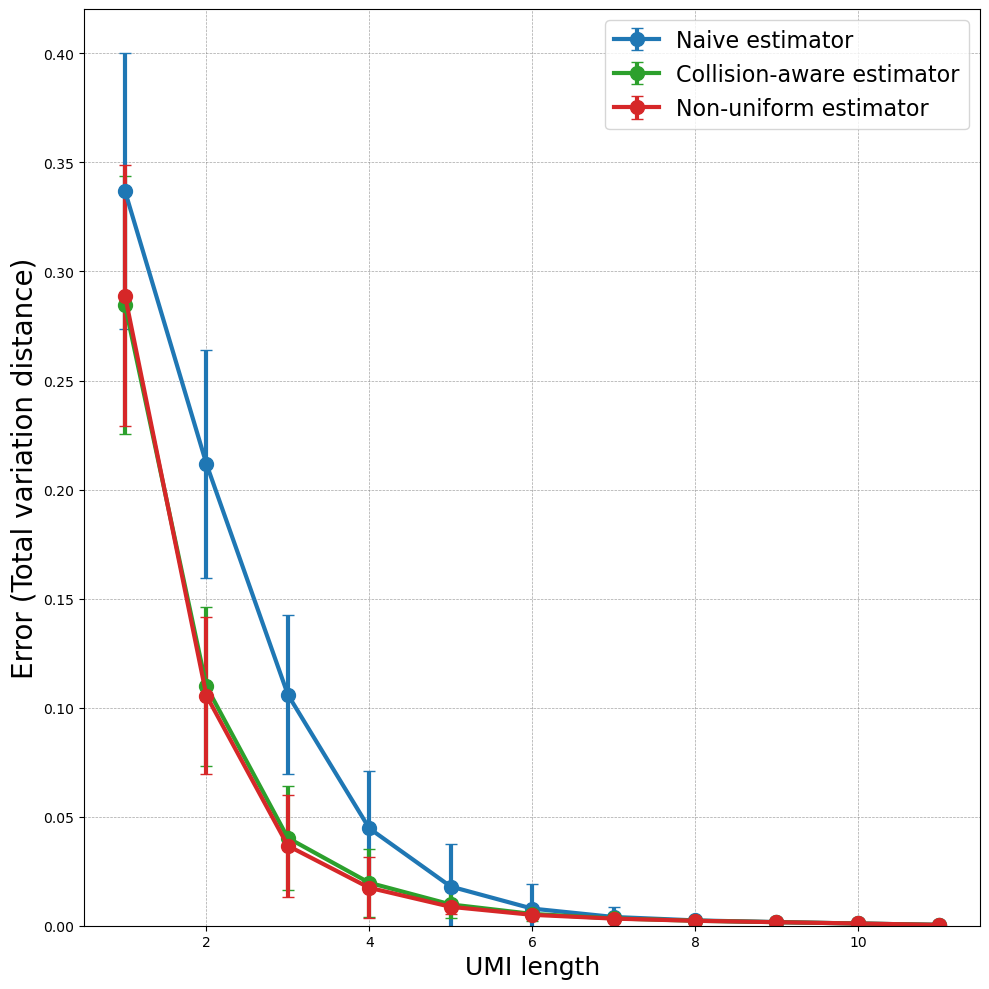

In [42]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted unif matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_unif_matrices"
# common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" 
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    unif_adata_dict[i] = sc.read_h5ad(path)
    
# Loadin the inverted non-unif matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    non_unif_adata_dict[i] = sc.read_h5ad(path)
non_unif_adata_dict[12] = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []
mean_errors3 = []
std_errors3 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for unif_matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = unif_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts2 >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))
    
    errors3 = []
    for barcode in gt_adata12.obs_names:
        index3 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts3 = non_unif_adata_dict[i].X[index3]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts3, np.ndarray):
            gene_counts3 = gene_counts3.toarray().flatten()
        else:
            gene_counts3 = gene_counts3.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts3
        mask = gene_counts3 >= 1
        gene_counts3 = gene_counts3[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts3)
        sorted_gene_counts3 = gene_counts3[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error3 = tvd(sorted_gene_counts3, sorted_gene_counts_gt)
        errors3.append(error3)  
        
    mean_errors3.append(np.mean(errors3))
    std_errors3.append(np.std(errors3))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)


# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#d62728',        # Red for Non-uniform Estimator
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()

#### All genes, without MALAT1 

[0.3245063090841096, 0.19813572304361782, 0.0938038065659219, 0.0370260266665543, 0.014703074521474343, 0.006759437175835562, 0.0037195522253422693, 0.002396582346403479, 0.0016720546536448564, 0.0010380263452730108, 0.0003920022840447437, 0.0]
[0.27592121294839544, 0.09302549555737695, 0.03259752006512591, 0.015122255823627277, 0.007707704285966329, 0.00466053719055167, 0.0031653597149361693, 0.002259666292473848, 0.001642263151342991, 0.0010336253561135616, 0.00039215804222064867, 0.0]


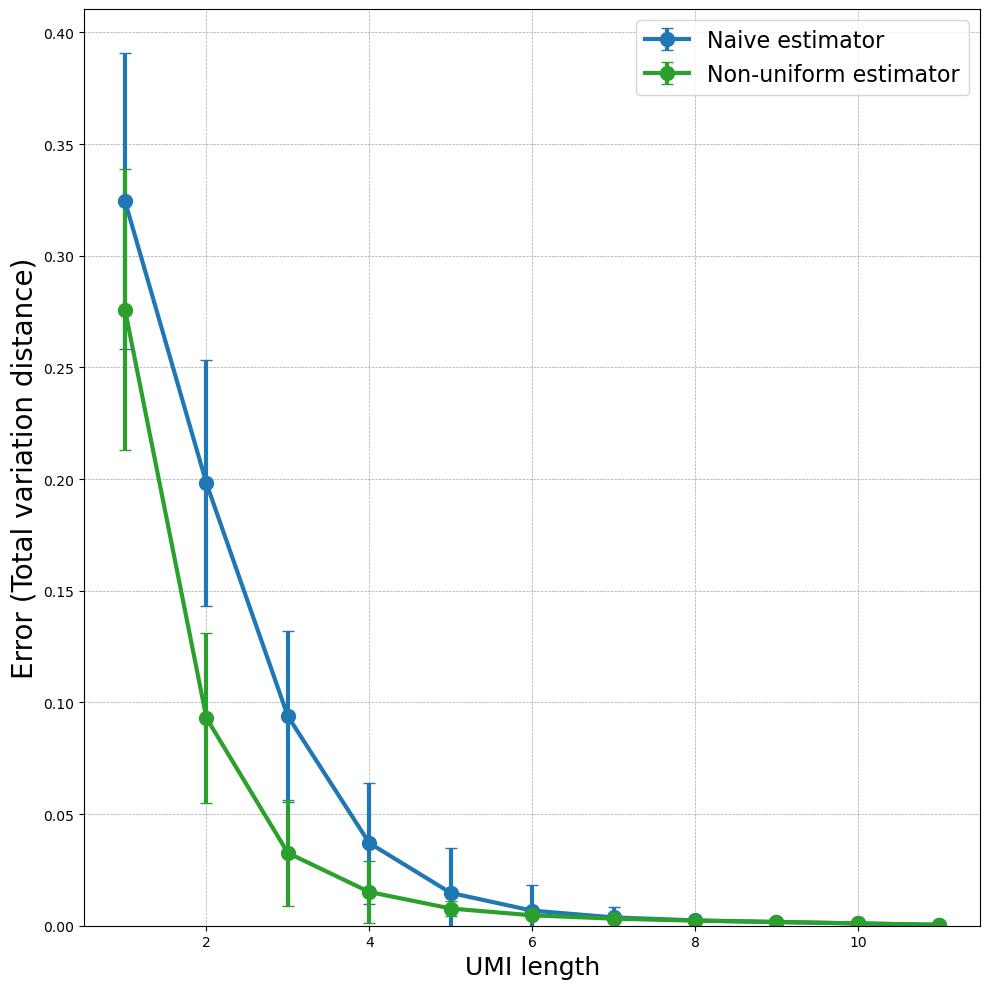

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

remove = np.array(['MALAT1'])  # <-- replace with your list

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# # Loading the inverted unif matrices
# common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_unif_matrices"
# unif_adata_dict = {}
# for i in range(1, 13):
#     path = f"{common_path2}/adata_{i}.h5ad"
#     adata = sc.read_h5ad(path)
#     adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
#     unif_adata_dict[i] = adata

# Loading the inverted non-unif matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata
# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
# mean_errors2 = []
# std_errors2 = []
mean_errors3 = []
std_errors3 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # # Errors for unif_matrices
    # errors2 = []
    # for barcode in gt_adata12.obs_names:
    #     index2 = np.where(unif_adata_dict[i].obs_names == barcode)[0][0]
    #     index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
    #     # Extract gene counts
    #     gene_counts2 = unif_adata_dict[i].X[index2]
    #     gene_counts_gt = gt_adata12.X[index_gt]
        
    #     # Convert to dense array if necessary
    #     if not isinstance(gene_counts2, np.ndarray):
    #         gene_counts2 = gene_counts2.toarray().flatten()
    #     else:
    #         gene_counts2 = gene_counts2.flatten()
        
    #     if not isinstance(gene_counts_gt, np.ndarray):
    #         gene_counts_gt = gene_counts_gt.toarray().flatten()
    #     else:
    #         gene_counts_gt = gene_counts_gt.flatten()
        
    #     # Filter for non-zero counts in gene_counts2
    #     mask = gene_counts2 >= 1
    #     gene_counts2 = gene_counts2[mask]
    #     gene_counts_gt = gene_counts_gt[mask]
        
    #     # Sort the gene counts
    #     sorted_indices = np.argsort(gene_counts2)
    #     sorted_gene_counts2 = gene_counts2[sorted_indices]
    #     sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
    #     # Compute TVD
    #     error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
    #     errors2.append(error2)
    
    # mean_errors2.append(np.mean(errors2))
    # std_errors2.append(np.std(errors2))
    
    errors3 = []
    for barcode in gt_adata12.obs_names:
        index3 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts3 = non_unif_adata_dict[i].X[index3]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts3, np.ndarray):
            gene_counts3 = gene_counts3.toarray().flatten()
        else:
            gene_counts3 = gene_counts3.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts3
        mask = gene_counts3 >= 1
        gene_counts3 = gene_counts3[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts3)
        sorted_gene_counts3 = gene_counts3[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error3 = tvd(sorted_gene_counts3, sorted_gene_counts_gt)
        errors3.append(error3)  
        
    mean_errors3.append(np.mean(errors3))
    std_errors3.append(np.std(errors3))

print(mean_errors)
# print(mean_errors2)
print(mean_errors3)


# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# plt.errorbar(
#     range(1, num_experiments), 
#     mean_errors3[:-1], 
#     yerr=std_errors3[:-1], 
#     fmt='o-', 
#     color='#d62728',        # Red for Non-uniform Estimator
#     ecolor='#d62728',
#     linewidth=3,
#     elinewidth=3, 
#     capsize=4, 
#     markersize=10,
#     label='Non-uniform estimator'
# )

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs

#### Protein Coding Genes

In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
keep = np.array(pc_list)  # <-- replace with your list

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, np.in1d(adata.var_names, keep)].copy()
    regular_adata_dict[i] = adata

# Loading the inverted unif matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_unif_matrices"
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, np.in1d(adata.var_names, keep)].copy()
    unif_adata_dict[i] = adata

# Loading the inverted non-unif matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, np.in1d(adata.var_names, keep)].copy()
    non_unif_adata_dict[i] = adata

adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, np.in1d(adata.var_names, keep)].copy()
non_unif_adata_dict[12] = adata

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []
mean_errors3 = []
std_errors3 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for unif_matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = unif_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts2 >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))
    
    errors3 = []
    for barcode in gt_adata12.obs_names:
        index3 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts3 = non_unif_adata_dict[i].X[index3]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts3, np.ndarray):
            gene_counts3 = gene_counts3.toarray().flatten()
        else:
            gene_counts3 = gene_counts3.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts3
        mask = gene_counts3 >= 1
        gene_counts3 = gene_counts3[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts3)
        sorted_gene_counts3 = gene_counts3[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error3 = tvd(sorted_gene_counts3, sorted_gene_counts_gt)
        errors3.append(error3)  
        
    mean_errors3.append(np.mean(errors3))
    std_errors3.append(np.std(errors3))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)


# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#d62728',        # Red for Non-uniform Estimator
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs

KeyboardInterrupt: 

## Cell Typist Stuff

### All Cells, All Genes

In [9]:
import scanpy as sc
import celltypist
import os

common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_adata_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # # Compute UMAP
    # sc.tl.umap(annotated_adata)

    # # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}", 
    #     show=True  # Display instead of saving
    # )

Processing UMI length: 1


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.75858657 0.         0.        ]
 [0.         0.         1.98234965 1.98234965 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.339187983916088


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_1.h5ad

Processing UMI length: 2


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.88963086 0.         0.        ]
 [0.         0.         1.81785399 1.81785399 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.856182134112137


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_2.h5ad

Processing UMI length: 3


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.77203496 0.         0.        ]
 [0.         0.         1.73704846 1.73704846 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.091091211753842


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_3.h5ad

Processing UMI length: 4


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71871507 0.         0.        ]
 [0.         0.         1.70244058 1.70244058 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.384202821527866


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_4.h5ad

Processing UMI length: 5


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69932847 0.         0.        ]
 [0.         0.         1.68845536 1.68845536 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.53055826603421


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_5.h5ad

Processing UMI length: 6


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69181976 0.         0.        ]
 [0.         0.         1.68451118 1.68451118 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58032586812956


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_6.h5ad

Processing UMI length: 7


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68989523 0.         0.        ]
 [0.         0.         1.68254754 1.68254754 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.591134130220313


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_7.h5ad

Processing UMI length: 8


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68857523 0.         0.        ]
 [0.         0.         1.68219112 1.68219112 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.587106699778493


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_8.h5ad

Processing UMI length: 9


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68761682 0.         0.        ]
 [0.         0.         1.68112297 1.68112297 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585883686303646


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_9.h5ad

Processing UMI length: 10


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68689889 0.         0.        ]
 [0.         0.         1.68005647 1.68005647 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_10.h5ad

Processing UMI length: 11


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.6861817  0.         0.        ]
 [0.         0.         1.67952385 1.67952385 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_11.h5ad

Processing UMI length: 12


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68582339 0.         0.        ]
 [0.         0.         1.6793464  1.6793464  0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad



In [10]:
import scanpy as sc
import celltypist
import os


common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices" # 1k
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" # 10k
# Define file paths
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_inv_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # Compute UMAP
    # sc.tl.umap(annotated_adata)

    # # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}(inverted)", 
    #     show=True  # Display instead of saving




Processing UMI length: 1


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71275466 0.         0.        ]
 [0.         0.         1.96977533 1.96977533 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.646527808042398


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_1.h5ad

Processing UMI length: 2


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.76168012 0.         0.        ]
 [0.         0.         1.73146049 1.73146049 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.040322759768344


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_2.h5ad

Processing UMI length: 3


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69470588 0.         0.        ]
 [0.         0.         1.7001125  1.7001125  0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.42178787770164


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_3.h5ad

Processing UMI length: 4


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69180773 0.         0.        ]
 [0.         0.         1.68909126 1.68909126 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.588980249672082


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_4.h5ad

Processing UMI length: 5


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69168243 0.         0.        ]
 [0.         0.         1.68430722 1.68430722 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.591336158572615


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_5.h5ad

Processing UMI length: 6


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68969506 0.         0.        ]
 [0.         0.         1.68338701 1.68338701 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.596974237189338


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_6.h5ad

Processing UMI length: 7


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.6893443  0.         0.        ]
 [0.         0.         1.68225802 1.68225802 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.595440919850006


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_7.h5ad

Processing UMI length: 8


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.688433   0.         0.        ]
 [0.         0.         1.68211692 1.68211692 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.588203100292052


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_8.h5ad

Processing UMI length: 9


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68757955 0.         0.        ]
 [0.         0.         1.68110378 1.68110378 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.586164353013288


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_9.h5ad

Processing UMI length: 10


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68688932 0.         0.        ]
 [0.         0.         1.68005154 1.68005154 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.584734141883686


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_10.h5ad

Processing UMI length: 11


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68617924 0.         0.        ]
 [0.         0.         1.67952258 1.67952258 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58468066210086


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_11.h5ad

Processing UMI length: 12


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68582277 0.         0.        ]
 [0.         0.         1.67934608 1.67934608 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.584666980224146


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_12.h5ad



##### CellTypist Plot

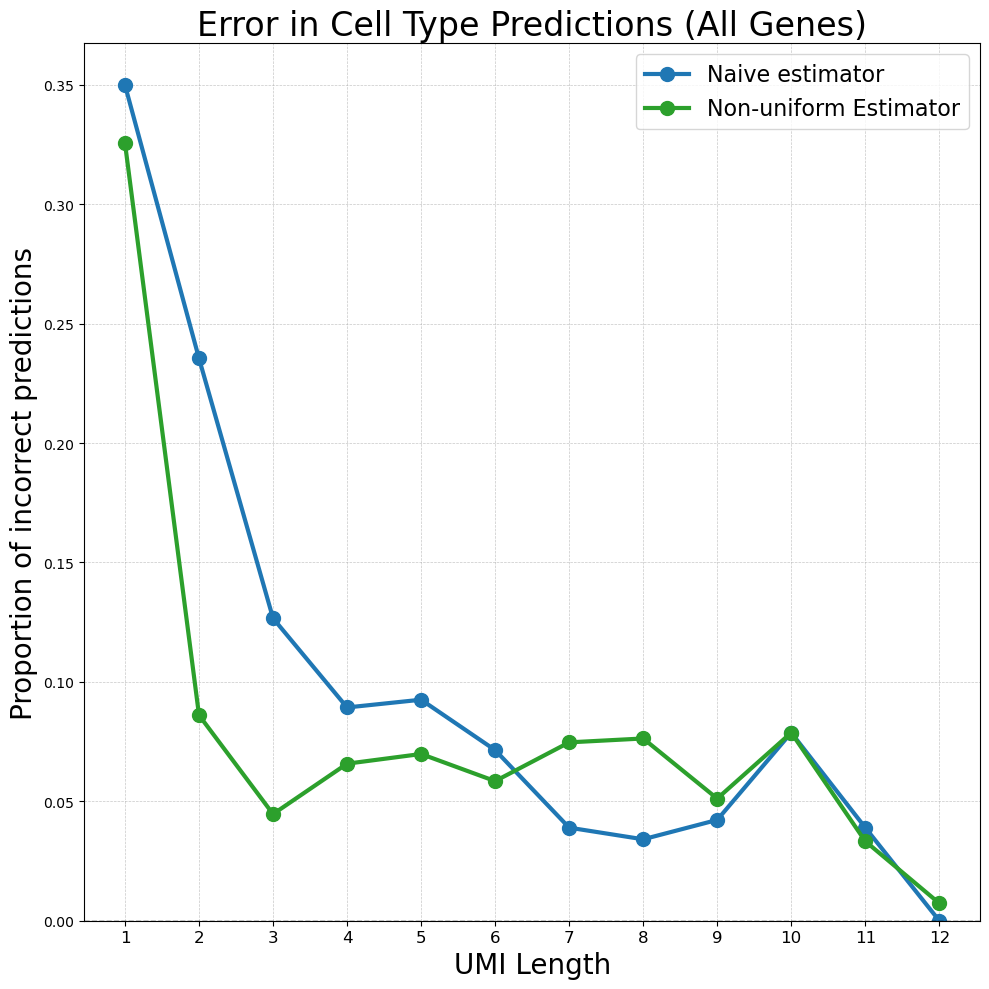

In [11]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Paths
regular_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Use UMI 12 as ground truth
ground_truth_adata = annotated_ads_reg[12]
common_cells = sorted(ground_truth_adata.obs_names)
ground_truth = ground_truth_adata.obs.loc[common_cells, 'majority_voting'].astype(str).values

# 3) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)

for i in range(1, 13):
    # Regular predictions aligned to UMI 12
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = ground_truth_adata.obs.loc[present, 'majority_voting'].astype(str).values
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to UMI 12
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = ground_truth_adata.obs.loc[present_inv, 'majority_voting'].astype(str).values
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

# 4) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Non-uniform Estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Error in Cell Type Predictions (All Genes)', fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
# out_file = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_error_plot_consensus.pdf"
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file)
plt.show()


#### All cells, All Genes, no MALAT1 

Processing UMI length: 1


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.75938232 0.         0.        ]
 [0.         0.         1.98342993 1.98342993 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.339187983916088


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_1.h5ad



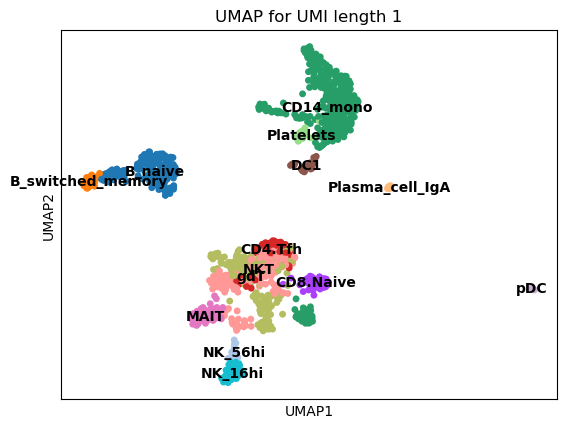

Processing UMI length: 2


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.89217822 0.         0.        ]
 [0.         0.         1.82131911 1.82131911 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.856182134112137


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_2.h5ad



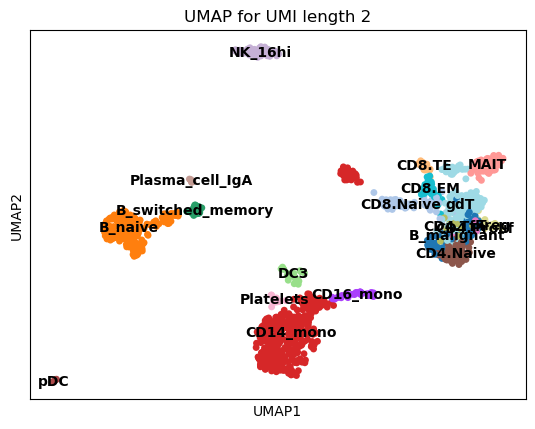

Processing UMI length: 3


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.78059725 0.         0.        ]
 [0.         0.         1.74714796 1.74714796 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.091091211753842


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_3.h5ad



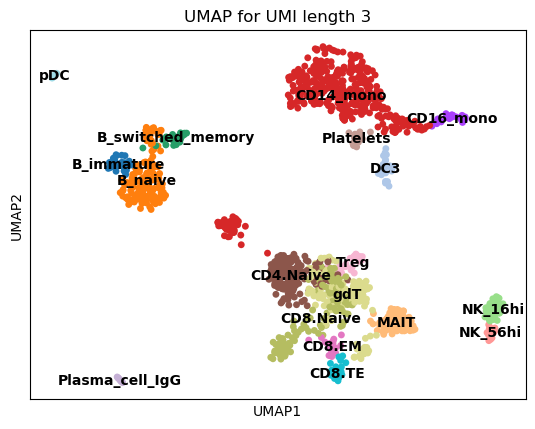

Processing UMI length: 4


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.73955974 0.         0.        ]
 [0.         0.         1.722356   1.722356   0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.384202821527866


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_4.h5ad



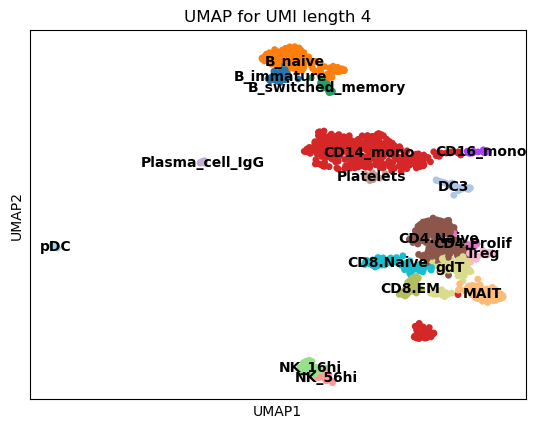

Processing UMI length: 5


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72766303 0.         0.        ]
 [0.         0.         1.7150308  1.7150308  0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.53055826603421


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_5.h5ad



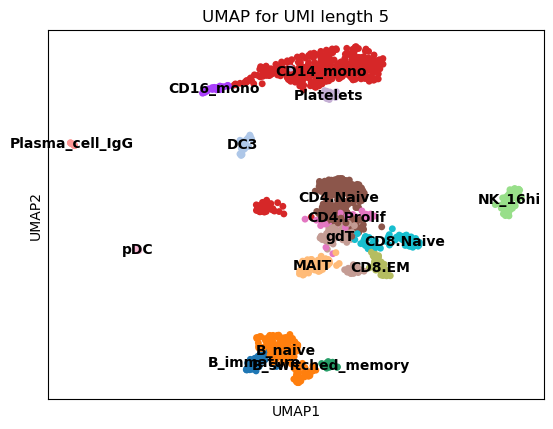

Processing UMI length: 6


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72399434 0.         0.        ]
 [0.         0.         1.71335127 1.71335127 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58032586812956


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_6.h5ad



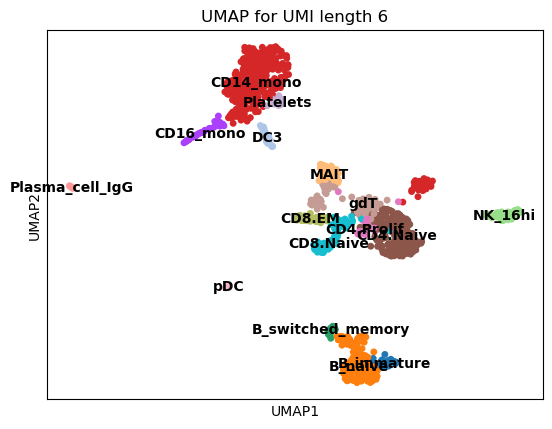

Processing UMI length: 7


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.7228597  0.         0.        ]
 [0.         0.         1.71167579 1.71167579 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.591134130220313


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_7.h5ad



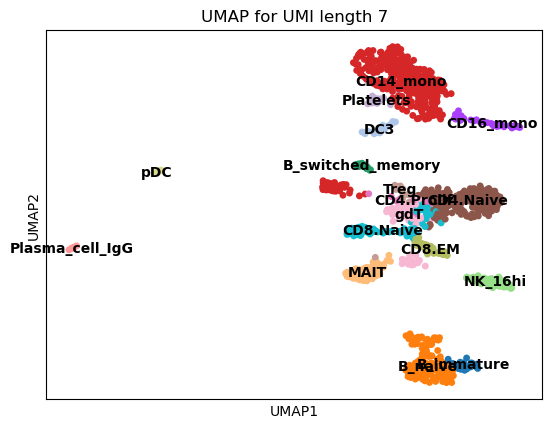

Processing UMI length: 8


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.7217269  0.         0.        ]
 [0.         0.         1.71130401 1.71130401 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.587106699778493


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_8.h5ad



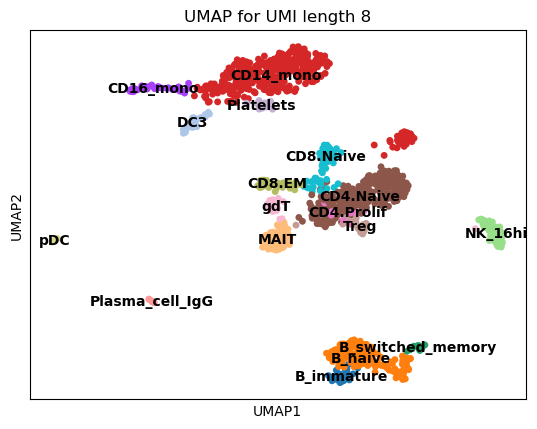

Processing UMI length: 9


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72134971 0.         0.        ]
 [0.         0.         1.71037543 1.71037543 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585883686303646


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_9.h5ad



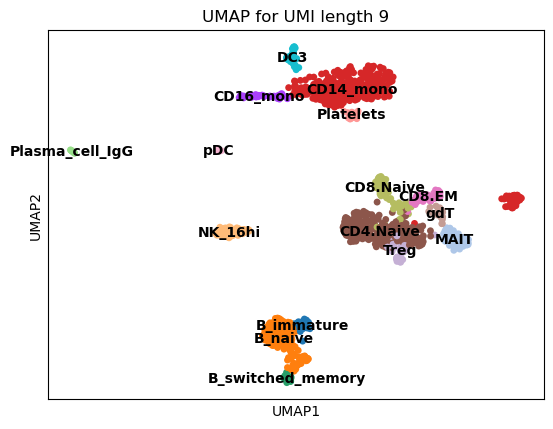

Processing UMI length: 10


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72059593 0.         0.        ]
 [0.         0.         1.70926277 1.70926277 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_10.h5ad



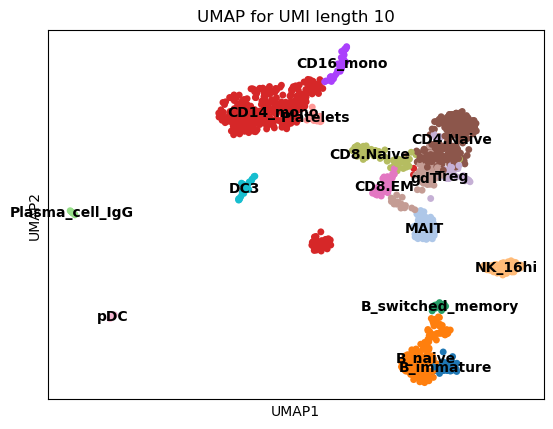

Processing UMI length: 11


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model
🧬 3376 features used for prediction


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71984298 0.         0.        ]
 [0.         0.         1.70870711 1.70870711 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_11.h5ad



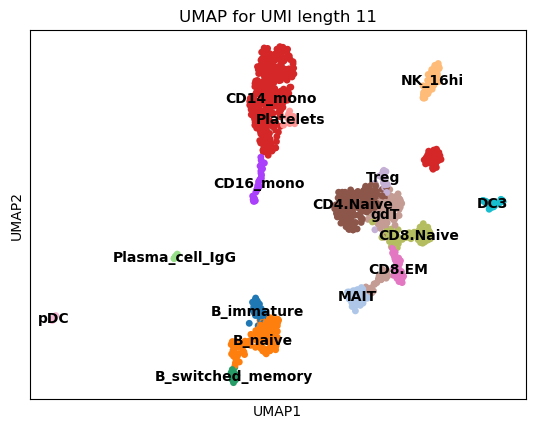

Processing UMI length: 12


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71946681 0.         0.        ]
 [0.         0.         1.70852199 1.70852199 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad



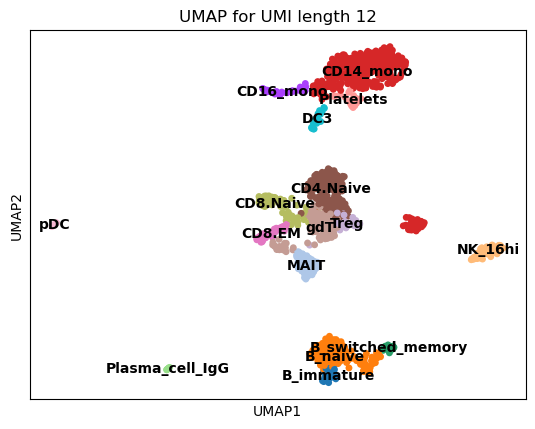

In [6]:
import scanpy as sc
import celltypist
import os
import numpy as np

common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Example remove array (replace with actual list of gene names)
remove = np.array(['MALAT1'])  

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Remove genes in the remove list
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_adata_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # Compute UMAP
    sc.tl.umap(annotated_adata)

    # Plot UMAP with majority voting labels
    sc.pl.umap(
        annotated_adata, 
        color=['majority_voting'], 
        legend_loc='on data', 
        title=f"UMAP for UMI length {i}", 
        show=True  # Display instead of saving
    )


Processing UMI length: 1


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model
🧬 3376 features used for prediction


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71402407 0.         0.        ]
 [0.         0.         1.97158511 1.97158511 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.646527808042398


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_1.h5ad



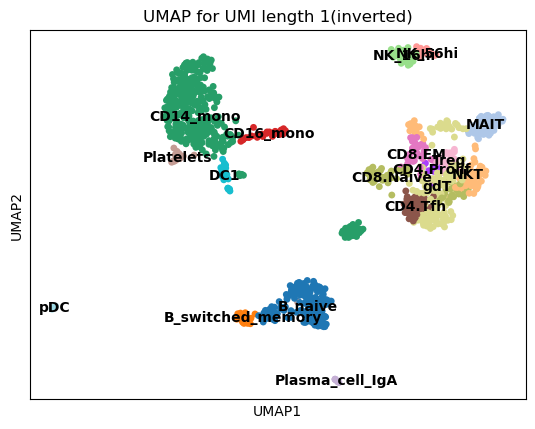

Processing UMI length: 2


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.76954974 0.         0.        ]
 [0.         0.         1.74325139 1.74325139 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.040322759768344


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_2.h5ad



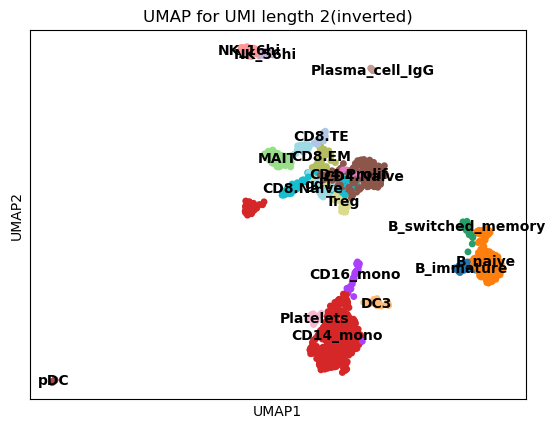

Processing UMI length: 3


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.73191168 0.         0.        ]
 [0.         0.         1.72101708 1.72101708 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.42178787770164


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_3.h5ad



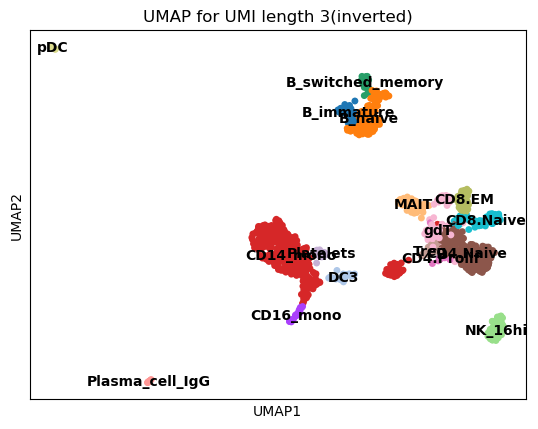

Processing UMI length: 4


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72579261 0.         0.        ]
 [0.         0.         1.71517749 1.71517749 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.588980249672082


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_4.h5ad



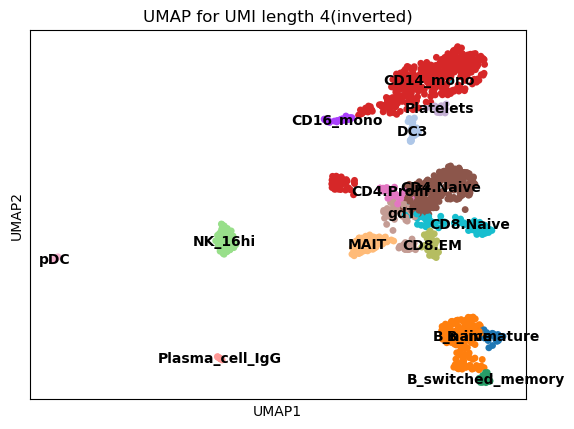

Processing UMI length: 5


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72400756 0.         0.        ]
 [0.         0.         1.71312622 1.71312622 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.591336158572615


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_5.h5ad



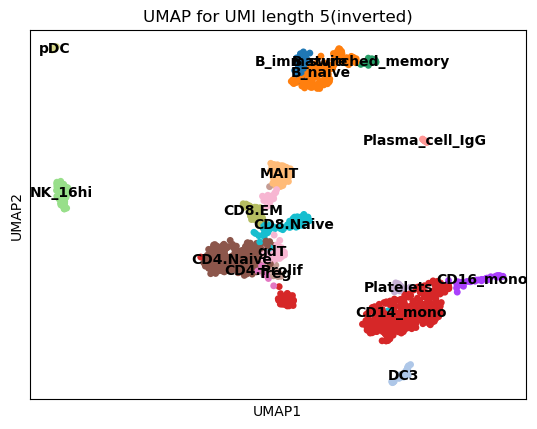

Processing UMI length: 6


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72304849 0.         0.        ]
 [0.         0.         1.71285905 1.71285905 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.596974237189338


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_6.h5ad



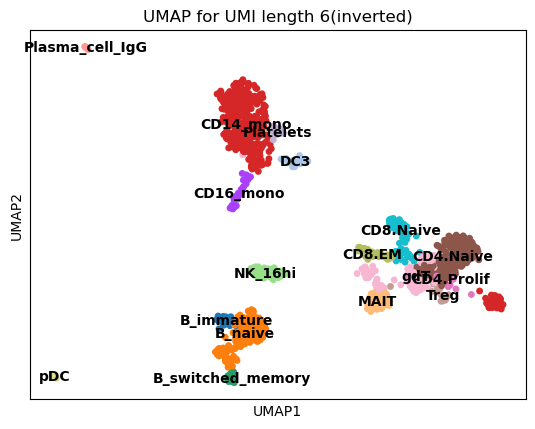

Processing UMI length: 7


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72261691 0.         0.        ]
 [0.         0.         1.71154901 1.71154901 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.595440919850006


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_7.h5ad



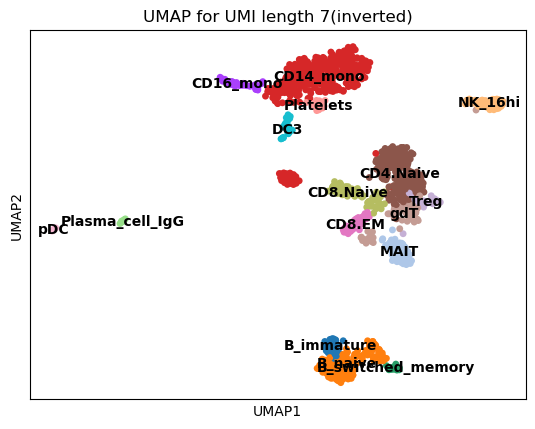

Processing UMI length: 8


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.7216642  0.         0.        ]
 [0.         0.         1.71127139 1.71127139 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.588203100292052


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_8.h5ad



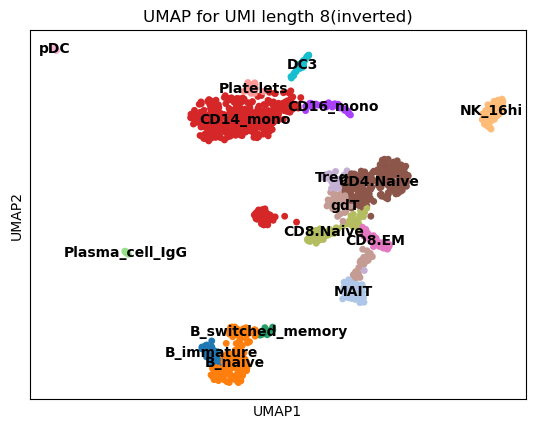

Processing UMI length: 9


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model
🧬 3376 features used for prediction


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72133358 0.         0.        ]
 [0.         0.         1.71036704 1.71036704 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.586164353013288


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_9.h5ad



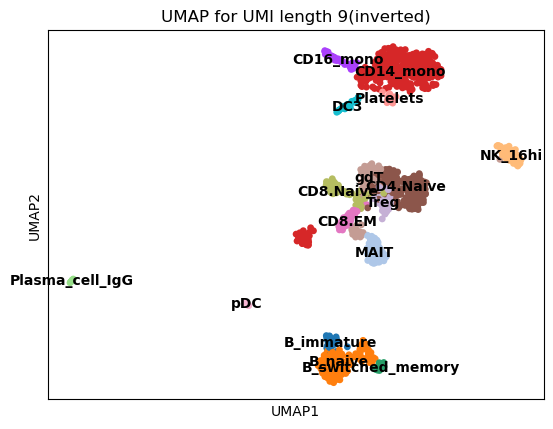

Processing UMI length: 10


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.72059179 0.         0.        ]
 [0.         0.         1.70926061 1.70926061 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.584734141883686


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_10.h5ad



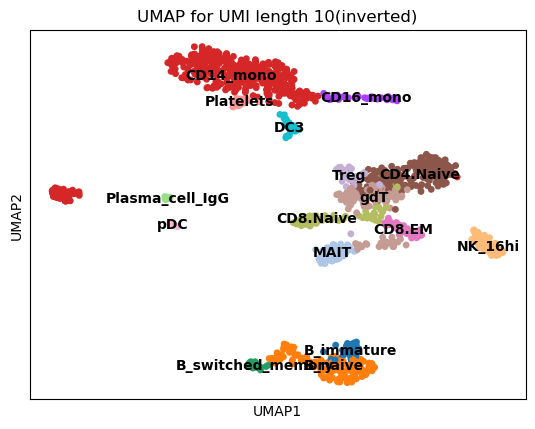

Processing UMI length: 11


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71984191 0.         0.        ]
 [0.         0.         1.70870655 1.70870655 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58468066210086


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_11.h5ad



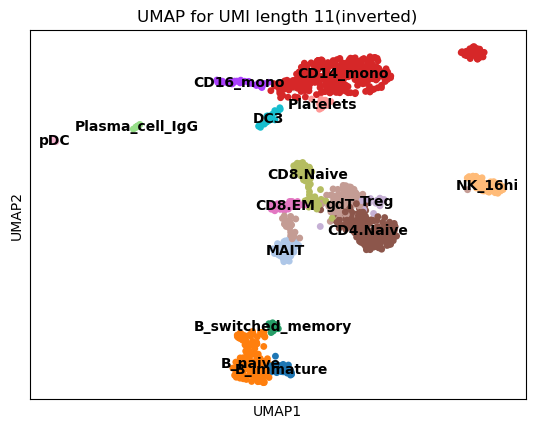

Processing UMI length: 12


🔬 Input data has 1232 cells and 28225 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71946654 0.         0.        ]
 [0.         0.         1.70852186 1.70852186 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.584666980224146


🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_12.h5ad



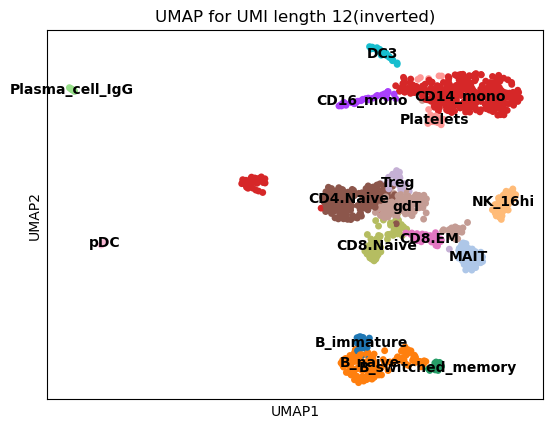

In [7]:
import scanpy as sc
import celltypist
import os


common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices" # 1k
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" # 10k
# Define file paths
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}


remove = np.array(['MALAT1'])  

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_inv_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # Compute UMAP
    sc.tl.umap(annotated_adata)

    # Plot UMAP with majority voting labels
    sc.pl.umap(
        annotated_adata, 
        color=['majority_voting'], 
        legend_loc='on data', 
        title=f"UMAP for UMI length {i}(inverted)", 
        show=True  # Display instead of saving
    )


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.39448052 0.21590909 0.15422078 0.08603896 0.07548701 0.05357143
 0.0487013  0.05275974 0.0487013  0.01542208 0.05275974 0.05194805]
[0.3538961  0.12256494 0.06574675 0.05600649 0.04707792 0.05194805
 0.03165584 0.02922078 0.02353896 0.05113636 0.05275974 0.05194805]
0.913961038961039


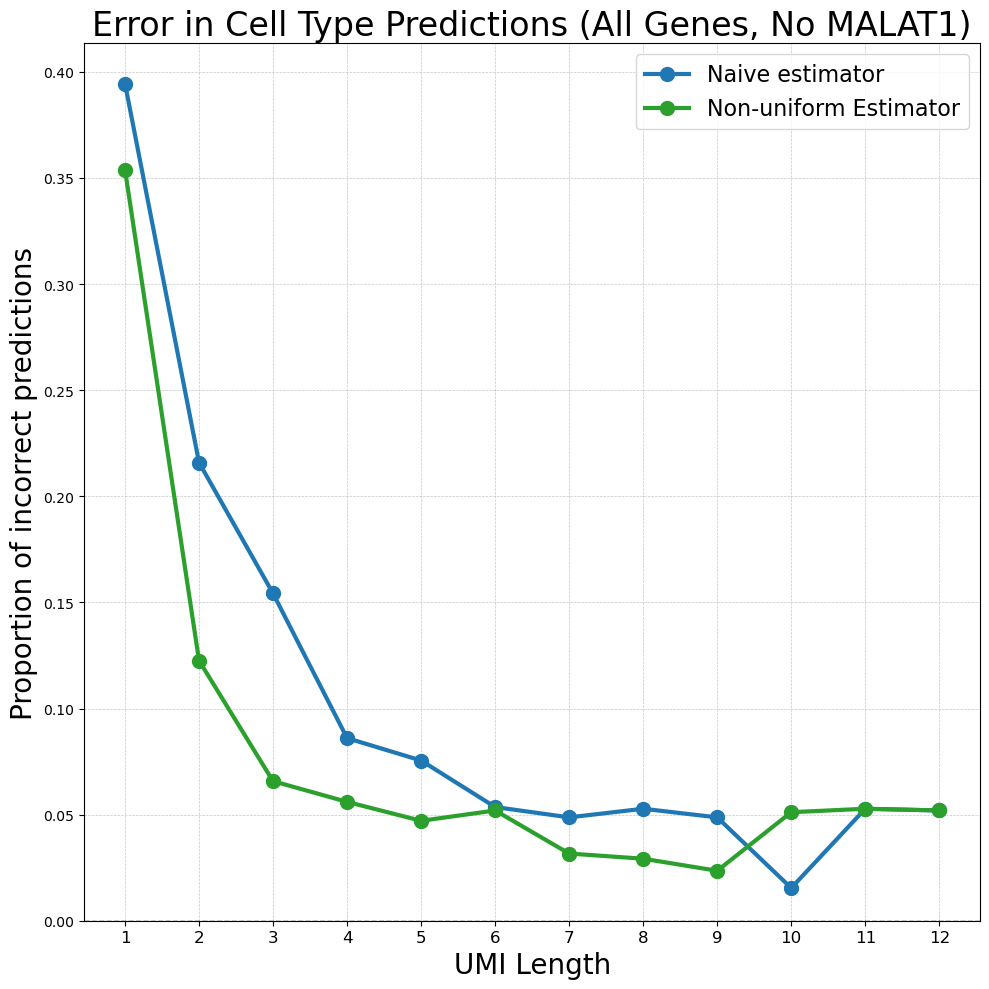

In [8]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Paths
regular_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices"

# regular_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
# inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Build consensus ground truth from UMI 8–12
#    a) find common cells across UMI 8–12
cells_8_12 = set(annotated_ads_reg[8].obs_names) 
for i in range(9, 13):
    cells_8_12 &= set(annotated_ads_reg[i].obs_names)
common_cells = sorted(cells_8_12)

#    b) majority‐vote per cell
consensus_labels = {}
for cell in common_cells:
    votes = [annotated_ads_reg[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# 3) Prepare ground truth array aligned to common_cells
ground_truth = np.array([consensus_labels[cell] for cell in common_cells], dtype=str)

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)
print(error_vector_reg)
print(error_vector_inv)

for i in range(1, 13):
    # Regular predictions aligned to consensus cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([consensus_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to consensus cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([consensus_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

print(error_vector_reg)
print(error_vector_inv)
print(1 - error_vector_reg[3])

# 5) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Non-uniform Estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Error in Cell Type Predictions (All Genes, No MALAT1)', fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
# out_file = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_error_plot_consensus.pdf"
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file)
plt.show()

### Protein Coding Genes 

In [18]:
import scanpy as sc
import celltypist
import os
import numpy as np

common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
keep = np.array(pc_list)

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Keep only genes in the keep list
    adata = adata[:, np.in1d(adata.var_names, keep)].copy()
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_adata_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # Compute UMAP
    sc.tl.umap(annotated_adata)

    # Plot UMAP with majority


Processing UMI length: 1


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.82001774 0.         0.         0.        ]
 [0.         2.04621362 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.3783837129967145


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_1.h5ad

Processing UMI length: 2


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.9460816  0.         0.         0.        ]
 [0.         1.87608775 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.8724364073853375


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_2.h5ad

Processing UMI length: 3


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.82910383 0.         0.         0.        ]
 [0.         1.79824715 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.09628444181422


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_3.h5ad

Processing UMI length: 4


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.78581209 0.         0.         0.        ]
 [0.         1.77244036 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.386392903021783


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_4.h5ad

Processing UMI length: 5


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.77352255 0.         0.         0.        ]
 [0.         1.76477721 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.532031815012163


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_5.h5ad

Processing UMI length: 6


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76960744 0.         0.         0.        ]
 [0.         1.76297434 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.581600326372001


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_6.h5ad

Processing UMI length: 7


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76853121 0.         0.         0.        ]
 [0.         1.76157527 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.592369231513084


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_7.h5ad

Processing UMI length: 8


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.7674566  0.         0.         0.        ]
 [0.         1.76117605 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58833121140644


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_8.h5ad

Processing UMI length: 9


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76718821 0.         0.         0.        ]
 [0.         1.76017897 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.587106699778493


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_9.h5ad

Processing UMI length: 10


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76665172 0.         0.         0.        ]
 [0.         1.7591833  0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585883686303646


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_10.h5ad

Processing UMI length: 11


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76598168 0.         0.         0.        ]
 [0.         1.75858657 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585883686303646


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_11.h5ad

Processing UMI length: 12


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76584775 0.         0.         0.        ]
 [0.         1.75858657 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585883686303646


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad



In [19]:
import scanpy as sc
import celltypist
import os


common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices" # 1k
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" # 10k
# Define file paths
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
keep = np.array(pc_list)

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    adata = adata[:, np.in1d(adata.var_names, keep)].copy()
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_inv_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # Compute UMAP
    sc.tl.umap(annotated_adata)

    # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}(inverted)", 
    #     show=True  # Display instead of saving
    # )


Processing UMI length: 1


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76676289 0.         0.         0.        ]
 [0.         2.02954879 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.671771632631569


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_1.h5ad

Processing UMI length: 2


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.81374375 0.         0.         0.        ]
 [0.         1.79231117 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.045224261564458


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_2.h5ad

Processing UMI length: 3


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.77701172 0.         0.         0.        ]
 [0.         1.7703036  0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.42327947409049


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_3.h5ad

Processing UMI length: 4


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.77110607 0.         0.         0.        ]
 [0.         1.76477073 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.590256747292496


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_4.h5ad

Processing UMI length: 5


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76961994 0.         0.         0.        ]
 [0.         1.76274196 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.592584445338735


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_5.h5ad

Processing UMI length: 6


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76859777 0.         0.         0.        ]
 [0.         1.76244836 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.598191180421898


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_6.h5ad

Processing UMI length: 7


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76827202 0.         0.         0.        ]
 [0.         1.76143987 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.596661305893798


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_7.h5ad

Processing UMI length: 8


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76738967 0.         0.         0.        ]
 [0.         1.76114121 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.589423852511462


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_8.h5ad

Processing UMI length: 9


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76717099 0.         0.         0.        ]
 [0.         1.76017001 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58738640176004


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_9.h5ad

Processing UMI length: 10


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model
🧬 3157 features used for prediction


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.7666473  0.         0.         0.        ]
 [0.         1.75918099 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585955413142306


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_10.h5ad

Processing UMI length: 11


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76598054 0.         0.         0.        ]
 [0.         1.75858597 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585902117426826


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_11.h5ad

Processing UMI length: 12


🔬 Input data has 1232 cells and 16736 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         1.76584747 0.         0.         0.        ]
 [0.         1.75858643 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58588848259617


🧬 3157 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_12.h5ad



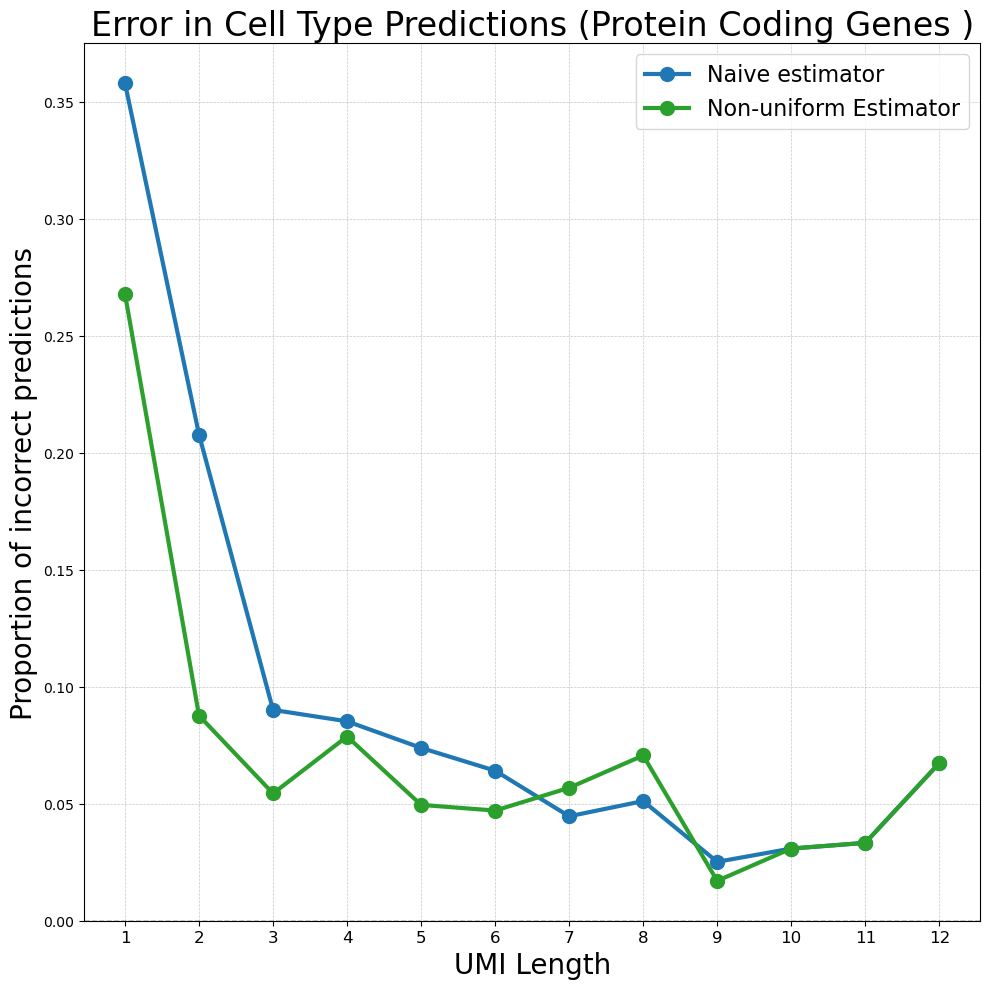

In [21]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Paths
regular_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/cell_annotations/annotated_inv_matrices"

# regular_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
# inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Build consensus ground truth from UMI 8–12
#    a) find common cells across UMI 8–12
cells_8_12 = set(annotated_ads_reg[8].obs_names) 
for i in range(9, 13):
    cells_8_12 &= set(annotated_ads_reg[i].obs_names)
common_cells = sorted(cells_8_12)

#    b) majority‐vote per cell
consensus_labels = {}
for cell in common_cells:
    votes = [annotated_ads_reg[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# 3) Prepare ground truth array aligned to common_cells
ground_truth = np.array([consensus_labels[cell] for cell in common_cells], dtype=str)

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)

for i in range(1, 13):
    # Regular predictions aligned to consensus cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([consensus_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to consensus cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([consensus_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

# 5) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Non-uniform Estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Error in Cell Type Predictions (Protein Coding Genes )', fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
# out_file = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_error_plot_consensus.pdf"
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file)
plt.show()